# Classification - Propensity to Purchase

## 0.0. Import Libraries

In [1]:
import pandas as pd
import numpy as np

import inflection

from ydata_profiling import ProfileReport

import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
import scikitplot as skplt

from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn import ensemble as en
from sklearn import linear_model as lm
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing as pp
from sklearn import neighbors as nh

import pickle

from tabulate import tabulate

C:\Users\Caio\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 0.1. Functions

In [2]:
#Functions
#Adjusting float data format
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(suppress=True)

#Setting Plot configuration
%matplotlib inline
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [25, 12]

#Rename dataframe columns
def rename_cols(df, train=True):
    if train == True:
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']
    else:
        cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']
    
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' ', '_')
    
    return df

#Feature Engineering
def feature_eng(df):
    #Mapping of gender feature
    map_gender = {'Male': 1, 'Female': 0}
    df['gender'] = df['gender'].map(map_gender)

    #Mapping of vehicle_damage feature
    map_vd = {'Yes': 1, 'No': 0}
    df['vehicle_damage'] = df['vehicle_damage'].map(map_vd)

    #Mapping of vehicle_age feature
    map_va = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
    df['vehicle_age'] = df['vehicle_age'].map(map_va)

    ##Label Encoder
    #le_gen = LabelEncoder()
    #le_vd = LabelEncoder()
    #df['gender'] = le_gen.fit_transform(df['gender'])
    #df['vehicle_damage'] = le_vd.fit_transform(df['vehicle_damage'])

    return df

def feature_opt(df):
    mms = MinMaxScaler()

    df['age'] = mms.fit_transform(df[['age']].values)

    freq_reg = df['region_code'].value_counts(normalize=True)
    df['region_code'] = df['region_code'].map(freq_reg)

    df['vehicle_age'] = mms.fit_transform(df[['vehicle_age']].values)

    freq_ap = df['annual_premium'].value_counts(normalize=True)
    df['annual_premium'] = df['annual_premium'].map(freq_ap)

    freq_psc = df['policy_sales_channel'].value_counts(normalize=True)
    df['policy_sales_channel'] = df['policy_sales_channel'].map(freq_psc)

    df['vintage'] = mms.fit_transform(df[['vintage']].values)

    return df

#Calculate Precision at K
def precision_at_k(data, k=10):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return (data.loc[k, 'precision_at_k'], data) 
            
#Calculate Recall at K
def recall_at_k(data, k=10):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return (data.loc[ k, 'recall_at_k'], data)

## 1.0. Data Description

### 1.0.1. Load SQL Data

In [3]:
##Input Credentials
#host = 'HOSTNAME-SQL_SERVER'
#port = 8080
#database = 'DB_INSURANCE'
#username = 'user'
#pwd = 'pass'

In [4]:
##Database Connection
#conn = pg.connect(user=username,
#                  password=pwd,
#                  host=host,
#                  port=port,
#                  database=database)

In [5]:
##Check SQL extension

### 1.0.2. Load Data

In [6]:
#Load train data
df = pd.read_csv('data/train.csv')

In [7]:
#Load test data
df_x = pd.read_csv('data/test.csv')

In [8]:
#Check train data
df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.00,0,> 2 Years,Yes,40454.00,26.00,217,1
1,2,Male,76,1,3.00,0,1-2 Year,No,33536.00,26.00,183,0
2,3,Male,47,1,28.00,0,> 2 Years,Yes,38294.00,26.00,27,1
3,4,Male,21,1,11.00,1,< 1 Year,No,28619.00,152.00,203,0
4,5,Female,29,1,41.00,1,< 1 Year,No,27496.00,152.00,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.00,1,1-2 Year,No,30170.00,26.00,88,0
381105,381106,Male,30,1,37.00,1,< 1 Year,No,40016.00,152.00,131,0
381106,381107,Male,21,1,30.00,1,< 1 Year,No,35118.00,160.00,161,0
381107,381108,Female,68,1,14.00,0,> 2 Years,Yes,44617.00,124.00,74,0


In [9]:
#Check test data
df_x

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.00,1,< 1 Year,No,35786.00,152.00,53
1,381111,Male,40,1,28.00,0,1-2 Year,Yes,33762.00,7.00,111
2,381112,Male,47,1,28.00,0,1-2 Year,Yes,40050.00,124.00,199
3,381113,Male,24,1,27.00,1,< 1 Year,Yes,37356.00,152.00,187
4,381114,Male,27,1,28.00,1,< 1 Year,No,59097.00,152.00,297
...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,Female,26,1,37.00,1,< 1 Year,No,30867.00,152.00,56
127033,508143,Female,38,1,28.00,0,1-2 Year,Yes,28700.00,122.00,165
127034,508144,Male,21,1,46.00,1,< 1 Year,No,29802.00,152.00,74
127035,508145,Male,71,1,28.00,1,1-2 Year,No,62875.00,26.00,265


## 1.1. Data Dimensions

In [10]:
#Counting number of rows and columns of the dataset
print('Train Rows: {}'.format(df.shape[0]))
print('Train Cols: {}'.format(df.shape[1]))
print('----------')
print('Test Rows: {}'.format(df_x.shape[0]))
print('Test Cols: {}'.format(df_x.shape[1]))

Train Rows: 381109
Train Cols: 12
----------
Test Rows: 127037
Test Cols: 11


## 1.2. Rename Columns

In [11]:
#Rename columns of datasets
df = rename_cols(df, train=True)
df_x = rename_cols(df_x, train=False)

## 1.3. Data Types

In [12]:
#Checking train data types
df.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [13]:
#Checking test data types
df_x.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
dtype: object

## 1.4. Check NA

In [14]:
#Check of NA's values of train dataset
df.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

In [15]:
#Check of NA's values of test dataset
df_x.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
dtype: int64

## 1.5. Data Descriptive

In [16]:
#Check train data balance
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.00,190555.00,110016.84,1.00,95278.00,190555.00,285832.00,381109.00
age,381109.00,38.82,15.51,20.00,25.00,36.00,49.00,85.00
driving_license,381109.00,1.00,0.05,0.00,1.00,1.00,1.00,1.00
region_code,381109.00,26.39,13.23,0.00,15.00,28.00,35.00,52.00
previously_insured,381109.00,0.46,0.50,0.00,0.00,0.00,1.00,1.00
annual_premium,381109.00,30564.39,17213.16,2630.00,24405.00,31669.00,39400.00,540165.00
policy_sales_channel,381109.00,112.03,54.20,1.00,29.00,133.00,152.00,163.00
vintage,381109.00,154.35,83.67,10.00,82.00,154.00,227.00,299.00
response,381109.00,0.12,0.33,0.00,0.00,0.00,0.00,1.00


In [17]:
#Check test data balance
df_x.describe().T

,count,mean,std,min,25%,50%,75%,max
id,127037.00,444628.00,36672.57,381110.00,412869.00,444628.00,476387.00,508146.00
age,127037.00,38.77,15.47,20.00,25.00,36.00,49.00,85.00
driving_license,127037.00,1.00,0.04,0.00,1.00,1.00,1.00,1.00
region_code,127037.00,26.46,13.21,0.00,15.00,28.00,35.00,52.00
previously_insured,127037.00,0.46,0.50,0.00,0.00,0.00,1.00,1.00
annual_premium,127037.00,30524.64,16945.30,2630.00,24325.00,31642.00,39408.00,472042.00
policy_sales_channel,127037.00,111.80,54.37,1.00,26.00,135.00,152.00,163.00
vintage,127037.00,154.32,83.66,10.00,82.00,154.00,227.00,299.00


## 1.6. Pandas Profilling

In [18]:
#Report for External Data Analysis
prof = ProfileReport(df)
prof.to_file(output_file='Profile_Report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 2.0. Exploratory Data Analysis - EDA

In [19]:
#Dataset backup
df1 = df.copy()

### **Pandas Profiling Feature Analysis for EDA**

- Total of Observations: 381.109

- Total of Features: 12

- Total of Numeric Features: 6

- Total of Categoric Features: 5

- Total of Boolean Features: 1

**Features:**

- response (Target Variable): 0 (88%) x 1 (12%)

- gender: Female (54%) x Male (46%) - Balanced Data

- age: 24, 23, 22, 25, 21, 26 (32%) - Data Concentration

- driving_license: 1 (99.8%) x 0 (0.2%) - Data Concentration

- region_code: 28 (28%), 8 (9%) - Data Concentration

- previously_insured: 0 (54%) x 1 (46%) - Balanced Data

- vehicle_age: 1-2 Year (53%) x <1 Year (43%) x > 2 Years (4%)

- vehicle_damage: True (50.5%) x False (49.5%) - Balanced Data

- annual_premium: 2630 (17%) - Data Concentration

- policy_sales_channel: 152 (35%) x 26 (21%) x 124 (19%) - 75% Data Concentration

- vintage - Pulverized Data


**Hight Correlation:**

- Negative:
    - policy_sales_channel x age 

- Positive: 
    - vehicle_damage x previusly_insured

- Target Variable:
    - Positive: vehicle_damage, age, vehicle_age
    - Negative: previously_insured

---

### 2.1. Univariate Analysis

In [20]:
#Split Numerical and Categorical datasets
num_ft = df.select_dtypes(include=['float','int'])
cat_ft = df.select_dtypes(exclude=['float','int','datetime'])

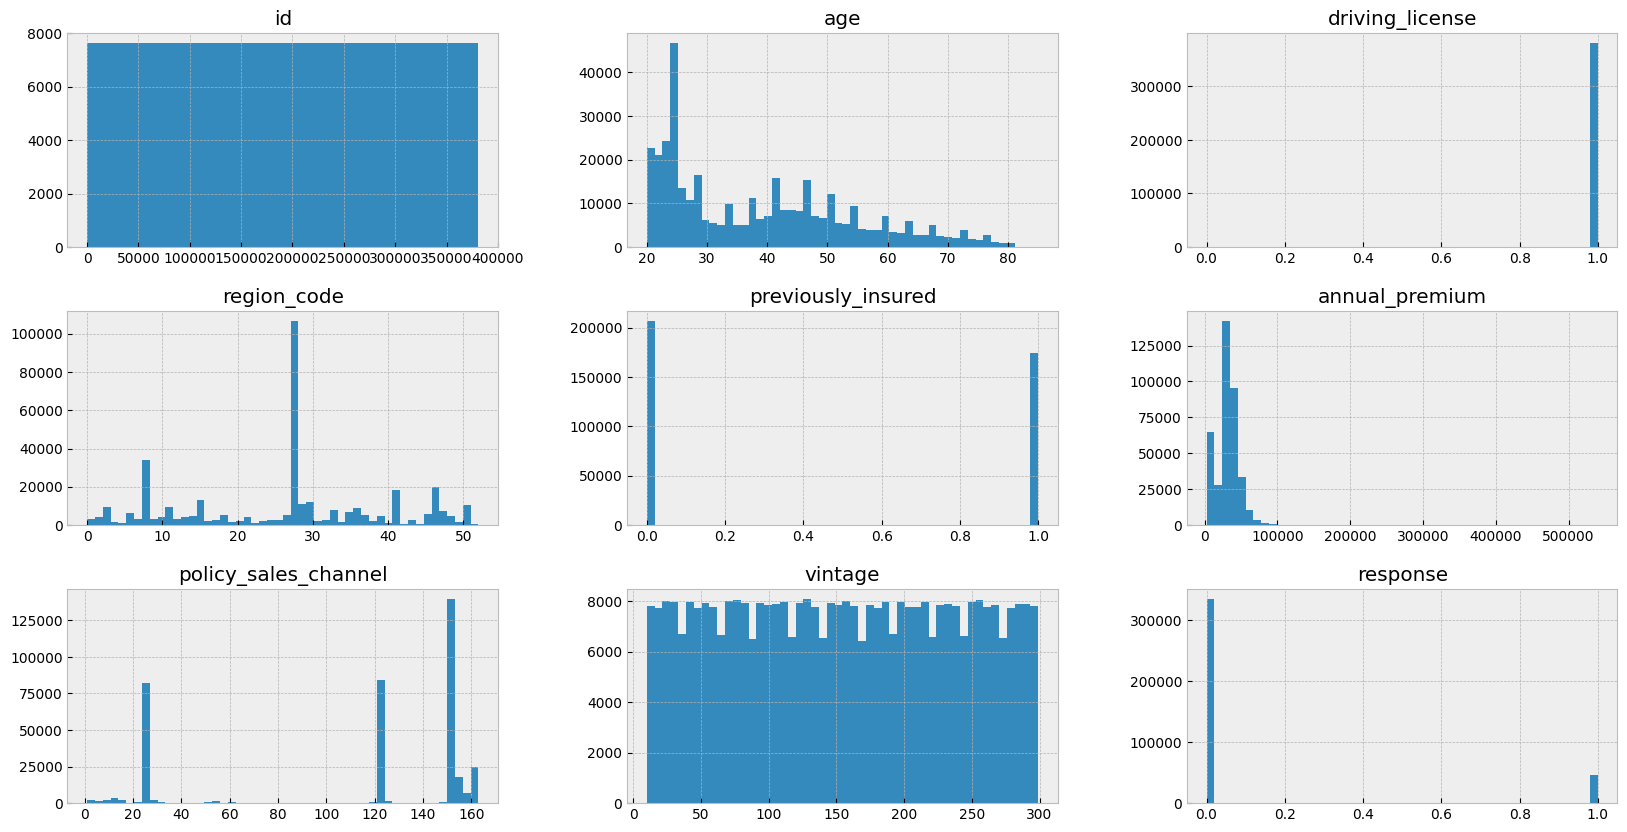

In [21]:
#Plot Histograms
num_ft.hist(bins=50, figsize=(20,10));

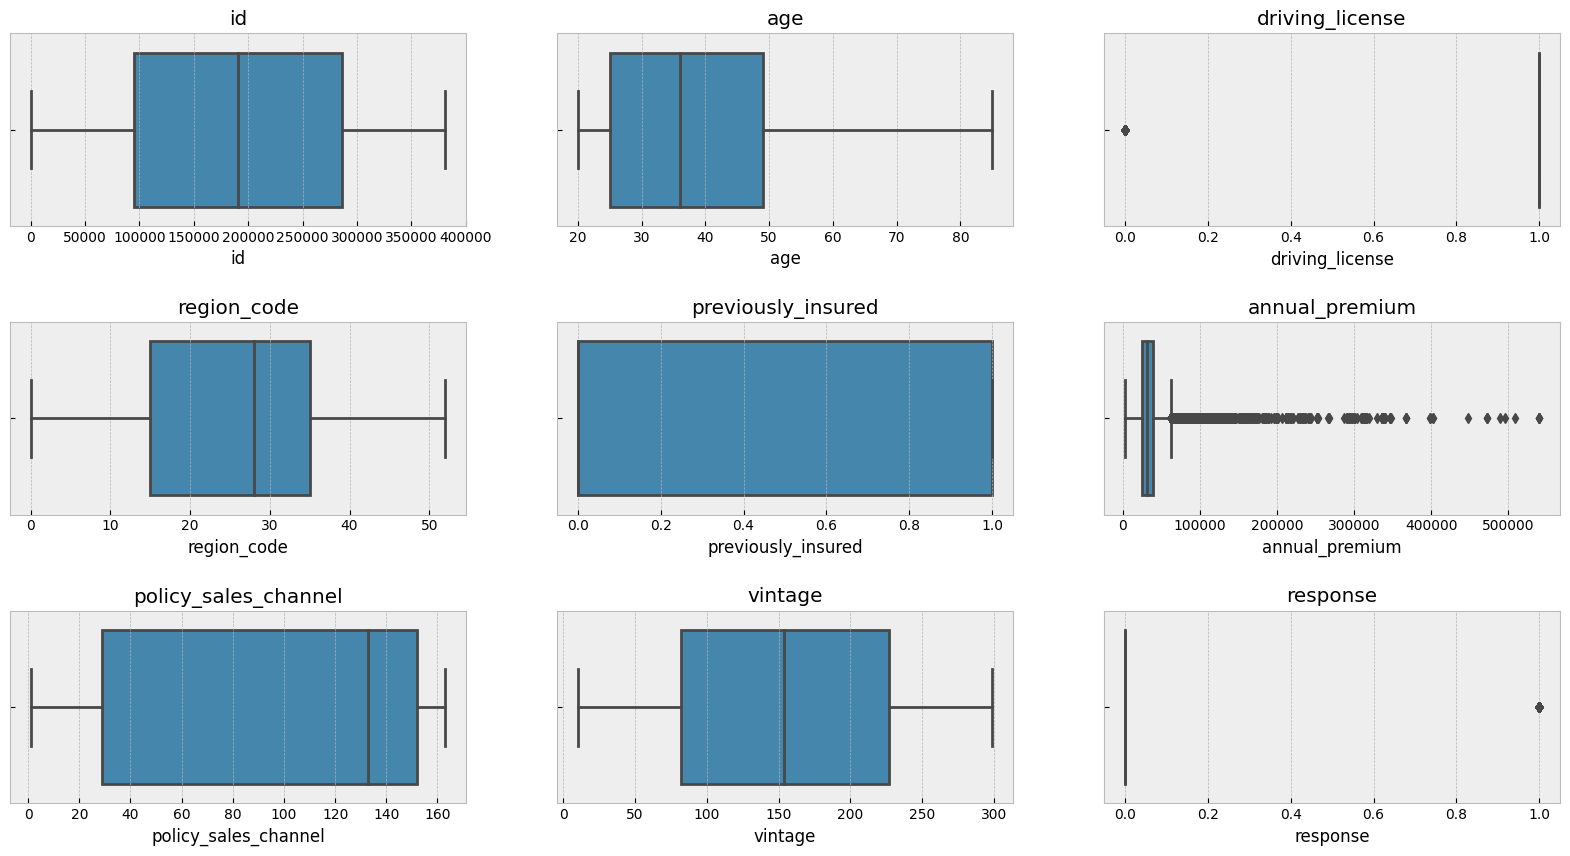

In [22]:
#Plot Boxplots
cols_plot = num_ft.columns

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

#Find axes with Divmod
for i, column in enumerate(cols_plot):
    row, col = divmod(i, 3)
    ax = axes[row, col]

    #Plot all Boxplots
    sns.boxplot(num_ft, x=column, ax=ax)
    ax.set_title(column)

### 2.2. Bivariate Analysis

**Hypothesis Definition**

1. Customers with already damaged cars tend to take out insurance **-> True**
2. Older clients tend to take out insurance **-> False**
3. Male clients are more likely to take out insurance **-> True**
4. Customers with newer cars tend to take out insurance **-> True**
5. Already insured customers tend to take out insurance **-> False**
---
In Portuguese Language:

1. Clientes com carros já danificados tendem a contratar seguro **-> Verdadeira**
2. Clientes mais velhos tendem a contratar seguro **-> Falsa**
3. Clientes homens tem maior tendência a contratar seguro **-> Verdadeira**
4. Clientes com carros mais novos tendem a contratar seguro **-> Verdadeira**
5. Clientes já assegurados tendem a contratar seguro **-> Falsa**

In [23]:
#Hypothesis 1 - Customers with already damaged cars tend to take out insurance - TRUE
tab = pd.pivot_table(df1, index='vehicle_damage', columns='response', values='id', aggfunc='count')

#Show percentage values by rows
row_totals = tab.sum(axis=1)
tab_percent_row = tab.div(row_totals, axis=0) * 100
tab_percent_row = tab_percent_row.style.format("{:.2f}%")
tab_percent_row

##Show percentage values by columns
#column_totals = tab.sum(axis=0)
#tab_percent_col = tab / column_totals * 100
#tab_percent_col = tab_percent_col.style.format("{:.2f}%")
#tab_percent_col

##Show percentage values by total
#grand_total = tab.sum().sum()
#tab_percent_total = tab / grand_total * 100
#tab_percent_total = tab_percent_total.style.format("{:.2f}%")
#tab_percent_total

response,0,1
vehicle_damage,,
No,99.48%,0.52%
Yes,76.23%,23.77%


c:\ProgramData\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\Anaconda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\Anaconda\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\ProgramData\Anaconda\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is depr

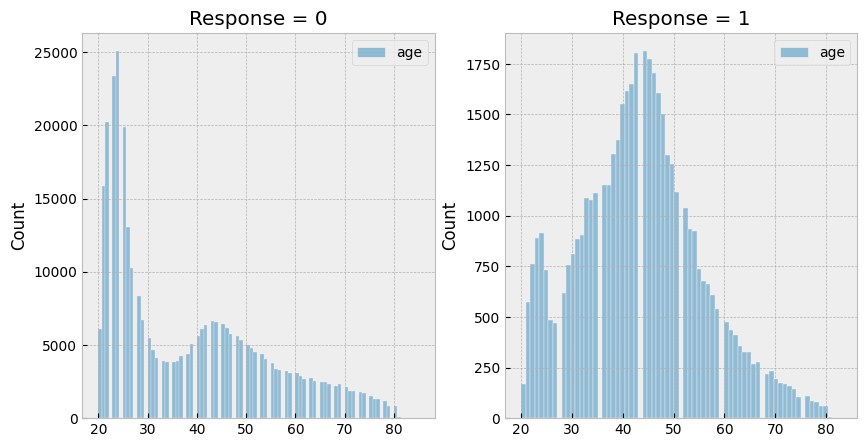

In [24]:
#Hypothesis 2 - Older clients tend to take out insurance - FALSE
aux1 = df1.loc[df1['response']==0, ['age']]
aux2 = df1.loc[df1['response']==1, ['age']]

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Response = 0')
#sns.histplot(data=aux1, x='age', y='id')
sns.histplot(aux1)

plt.subplot(1,2,2)
plt.title('Response = 1')
#sns.histplot(data=aux2, x='age', y='id')
sns.histplot(aux2)

plt.show();

In [25]:
#Hypothesis 3 - Male clients are more likely to take out insurance - TRUE
tab = pd.pivot_table(df1, index='gender', columns='response', values='id', aggfunc='count')

#Show percentage values by rows
row_totals = tab.sum(axis=1)
tab_percent_row = tab.div(row_totals, axis=0) * 100
tab_percent_row = tab_percent_row.style.format("{:.2f}%")
tab_percent_row

##Show percentage values by columns
#column_totals = tab.sum(axis=0)
#tab_percent_col = tab / column_totals * 100
#tab_percent_col = tab_percent_col.style.format("{:.2f}%")
#tab_percent_col

##Show percentage values by total
#grand_total = tab.sum().sum()
#tab_percent_total = tab / grand_total * 100
#tab_percent_total = tab_percent_total.style.format("{:.2f}%")
#tab_percent_total

response,0,1
gender,,
Female,89.61%,10.39%
Male,86.16%,13.84%


In [26]:
#Hypothesis 4 - Customers with newer cars tend to take out insurance - TRUE
tab = pd.pivot_table(df1, index='vehicle_age', columns='response', values='id', aggfunc='count')

##Show percentage values by rows
#row_totals = tab.sum(axis=1)
#tab_percent_row = tab.div(row_totals, axis=0) * 100
#tab_percent_row = tab_percent_row.style.format("{:.2f}%")
#tab_percent_row

#Show percentage values by columns
column_totals = tab.sum(axis=0)
tab_percent_col = tab / column_totals * 100
tab_percent_col = tab_percent_col.style.format("{:.2f}%")
tab_percent_col

##Show percentage values by total
#grand_total = tab.sum().sum()
#tab_percent_total = tab / grand_total * 100
#tab_percent_total = tab_percent_total.style.format("{:.2f}%")
#tab_percent_total

response,0,1
vehicle_age,,
1-2 Year,49.49%,74.52%
< 1 Year,47.12%,15.42%
> 2 Years,3.38%,10.07%


In [27]:
#Hypothesis 5 - Already insured customers tend to take out insurance - FALSE
tab = pd.pivot_table(df1, index='previously_insured', columns='response', values='id', aggfunc='count')

#Show percentage values by rows
row_totals = tab.sum(axis=1)
tab_percent_row = tab.div(row_totals, axis=0) * 100
tab_percent_row = tab_percent_row.style.format("{:.2f}%")
tab_percent_row

##Show percentage values by columns
#column_totals = tab.sum(axis=0)
#tab_percent_col = tab / column_totals * 100
#tab_percent_col = tab_percent_col.style.format("{:.2f}%")
#tab_percent_col

##Show percentage values by total
#grand_total = tab.sum().sum()
#tab_percent_total = tab / grand_total * 100
#tab_percent_total = tab_percent_total.style.format("{:.2f}%")
#tab_percent_total

response,0,1
previously_insured,,
0,77.45%,22.55%
1,99.91%,0.09%


## 3.0. Feature Engineering

In [28]:
#Dataset backup
df2 = df1.copy()

In [29]:
#Applying Feature Engineering Function
df2 = feature_eng(df2)

In [30]:
#Checking number of rows and columns of the dataset after Feature Engineering
print('Train Rows: {}'.format(df2.shape[0]))
print('Train Cols: {}'.format(df2.shape[1]))

Train Rows: 381109
Train Cols: 12


In [31]:
#Checking train data adjustments
df2

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,1,44,1,28.00,0,2,1,40454.00,26.00,217,1
1,2,1,76,1,3.00,0,1,0,33536.00,26.00,183,0
2,3,1,47,1,28.00,0,2,1,38294.00,26.00,27,1
3,4,1,21,1,11.00,1,0,0,28619.00,152.00,203,0
4,5,0,29,1,41.00,1,0,0,27496.00,152.00,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,74,1,26.00,1,1,0,30170.00,26.00,88,0
381105,381106,1,30,1,37.00,1,0,0,40016.00,152.00,131,0
381106,381107,1,21,1,30.00,1,0,0,35118.00,160.00,161,0
381107,381108,0,68,1,14.00,0,2,1,44617.00,124.00,74,0


In [32]:
#Checking train data types
df2.dtypes

id                        int64
gender                    int64
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age               int64
vehicle_damage            int64
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

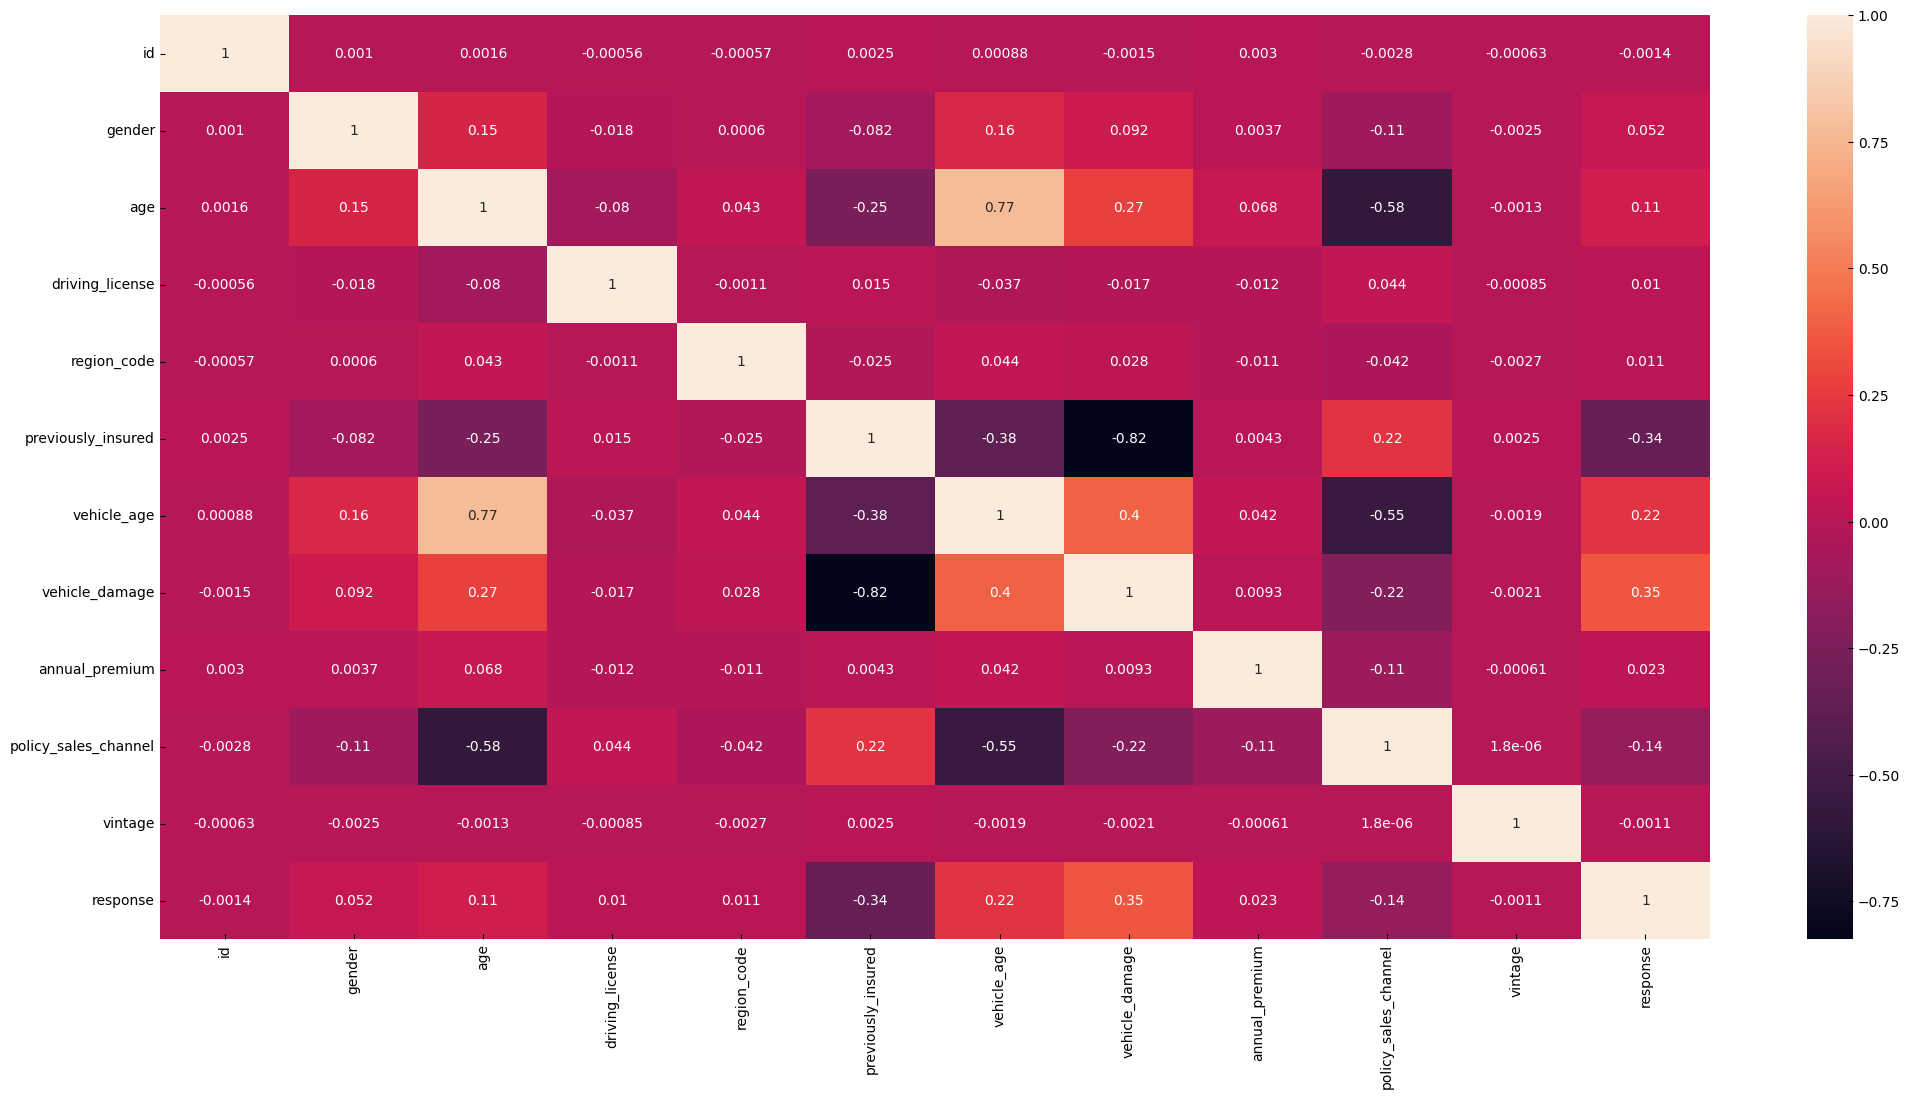

In [33]:
#Correlation Matrix after Feature Engineering
num_att = df2.select_dtypes(include=['int64', 'float64'])
hmap = num_att.corr(method='pearson')
sns.heatmap(hmap, annot=True);

## 4.0. Data Preparation

In [34]:
#Dataset backup
df3 = df2.copy()

In [35]:
#Checking data distribution for analysis of encoders
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.00,190555.00,110016.84,1.00,95278.00,190555.00,285832.00,381109.00
gender,381109.00,0.54,0.50,0.00,0.00,1.00,1.00,1.00
age,381109.00,38.82,15.51,20.00,25.00,36.00,49.00,85.00
driving_license,381109.00,1.00,0.05,0.00,1.00,1.00,1.00,1.00
region_code,381109.00,26.39,13.23,0.00,15.00,28.00,35.00,52.00
previously_insured,381109.00,0.46,0.50,0.00,0.00,0.00,1.00,1.00
vehicle_age,381109.00,0.61,0.57,0.00,0.00,1.00,1.00,2.00
vehicle_damage,381109.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00
annual_premium,381109.00,30564.39,17213.16,2630.00,24405.00,31669.00,39400.00,540165.00
policy_sales_channel,381109.00,112.03,54.20,1.00,29.00,133.00,152.00,163.00


### 4.1. Data Analysis for Preparation

gender: No Encoder

age: MinMaxScaler

driving_license: No Encoder

region_code: Frequency Encoding	

previously_insured: No Encoder	

vehicle_age: MinMaxScaler	

vehicle_damage: No Enconder

annual_premium: Frequency Encoding

policy_sales_channel: Frequency Encoding

vintage: MinMaxScaler


In [36]:
#Data Preparation
df3 = feature_opt(df3)

In [37]:
#Checking data distribution after Data Preparation
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.00,190555.00,110016.84,1.00,95278.00,190555.00,285832.00,381109.00
gender,381109.00,0.54,0.50,0.00,0.00,1.00,1.00,1.00
age,381109.00,0.29,0.24,0.00,0.08,0.25,0.45,1.00
driving_license,381109.00,1.00,0.05,0.00,1.00,1.00,1.00,1.00
region_code,381109.00,0.10,0.11,0.00,0.01,0.03,0.28,0.28
previously_insured,381109.00,0.46,0.50,0.00,0.00,0.00,1.00,1.00
vehicle_age,381109.00,0.30,0.28,0.00,0.00,0.50,0.50,1.00
vehicle_damage,381109.00,0.50,0.50,0.00,0.00,1.00,1.00,1.00
annual_premium,381109.00,0.03,0.06,0.00,0.00,0.00,0.00,0.17
policy_sales_channel,381109.00,0.21,0.13,0.00,0.19,0.21,0.35,0.35


In [38]:
#Checking data types after Data Preparation
df3.dtypes

id                        int64
gender                    int64
age                     float64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age             float64
vehicle_damage            int64
annual_premium          float64
policy_sales_channel    float64
vintage                 float64
response                  int64
dtype: object

## 5.0. Feature Selection

In [39]:
#Dataset backup
df4 = df3.copy()

In [40]:
#Split train dataset into features and target
X = df4.drop(['id', 'response'], axis=1)
y = df4['response']

#Split train dataset into train and test for valuation
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2)

### 5.1. Feature Importances

In [41]:
#Model Definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

#Data Preparation
x_train_n = X_train
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [42]:
#Analysis of Feature Importances
ft_imp = pd.DataFrame({'Feature': X.columns, 'Importance': forest.feature_importances_})
ft_imp = ft_imp.sort_values('Importance', ascending=False).head(10)

#Print results
print("Top 10 Important Features:")
print(ft_imp)

Top 10 Important Features:
                Feature  Importance
9               vintage        0.32
1                   age        0.18
7        annual_premium        0.18
3           region_code        0.11
6        vehicle_damage        0.08
8  policy_sales_channel        0.07
4    previously_insured        0.05
5           vehicle_age        0.02
0                gender        0.01
2       driving_license        0.00


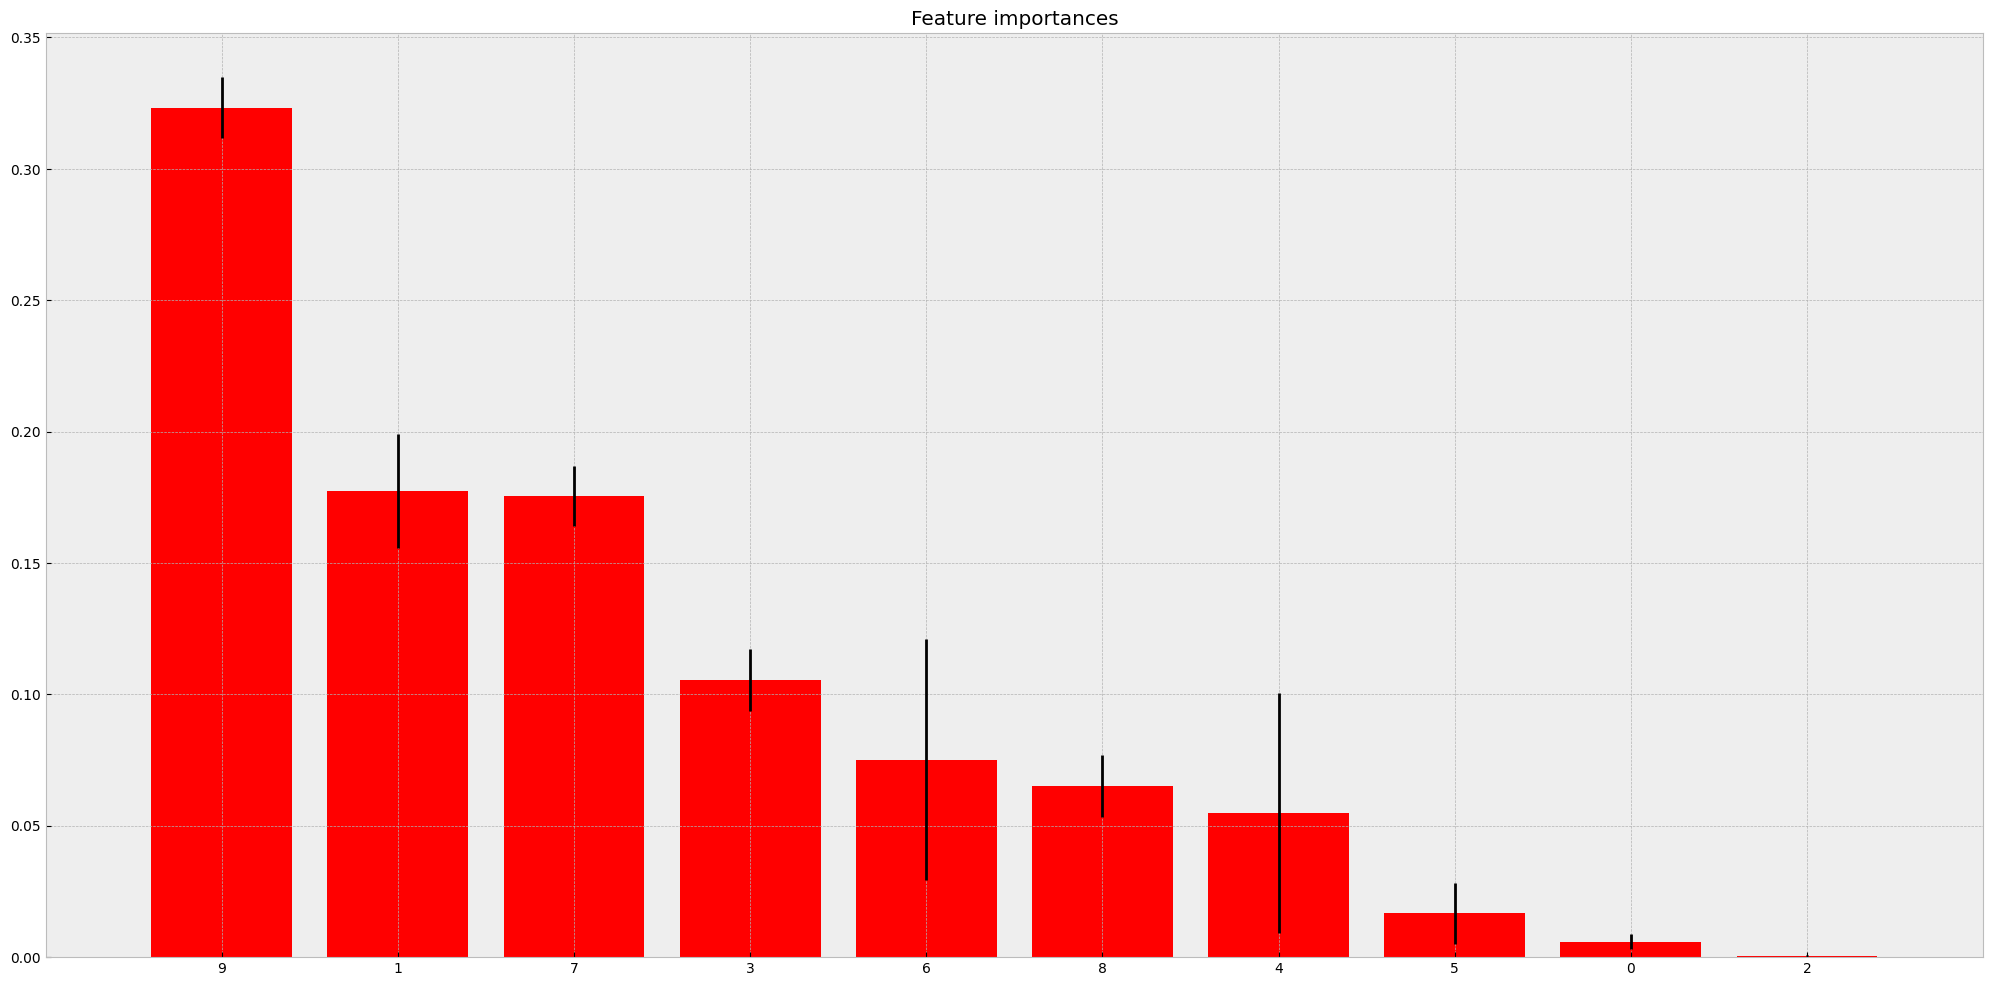

In [43]:
#Check the impurity-based feature importances of the forest
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 6.0. Machine Learning Model

In [44]:
#Select Features for the models
cols_sel = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 
            'previously_insured', 'vehicle_age', 'gender', 'driving_license']

X_train = X_train[cols_sel]

X_val = X_val[cols_sel]
y_val = y_val

#After performance tests of the models, better performance was identified when considering all variables, thus Feature Selection was disregarded in this case

### 6.1. Logistic Regression

In [45]:
#Model Definition
lr = lm.LogisticRegression(random_state=42) 

#Model Training
lr.fit(X_train, y_train)

#Model Prediction
yhat_lr = lr.predict(X_val)
yhat_lr_ = lr.predict_proba(X_val)

In [46]:
#Cross Validation LR
lr_cv = cross_val_score(lr, X, y, scoring='precision', cv=5)
print(lr_cv)
print('AVG CV: {:.5f}'.format(lr_cv.mean()))
print('STD CV: {:.5f}'.format(lr_cv.std()))

[0.23809524 0.3125     0.4        0.13793103 0.20833333]
AVG CV: 0.25937
STD CV: 0.08989


#### 6.1.1. Performance Logistic Regression

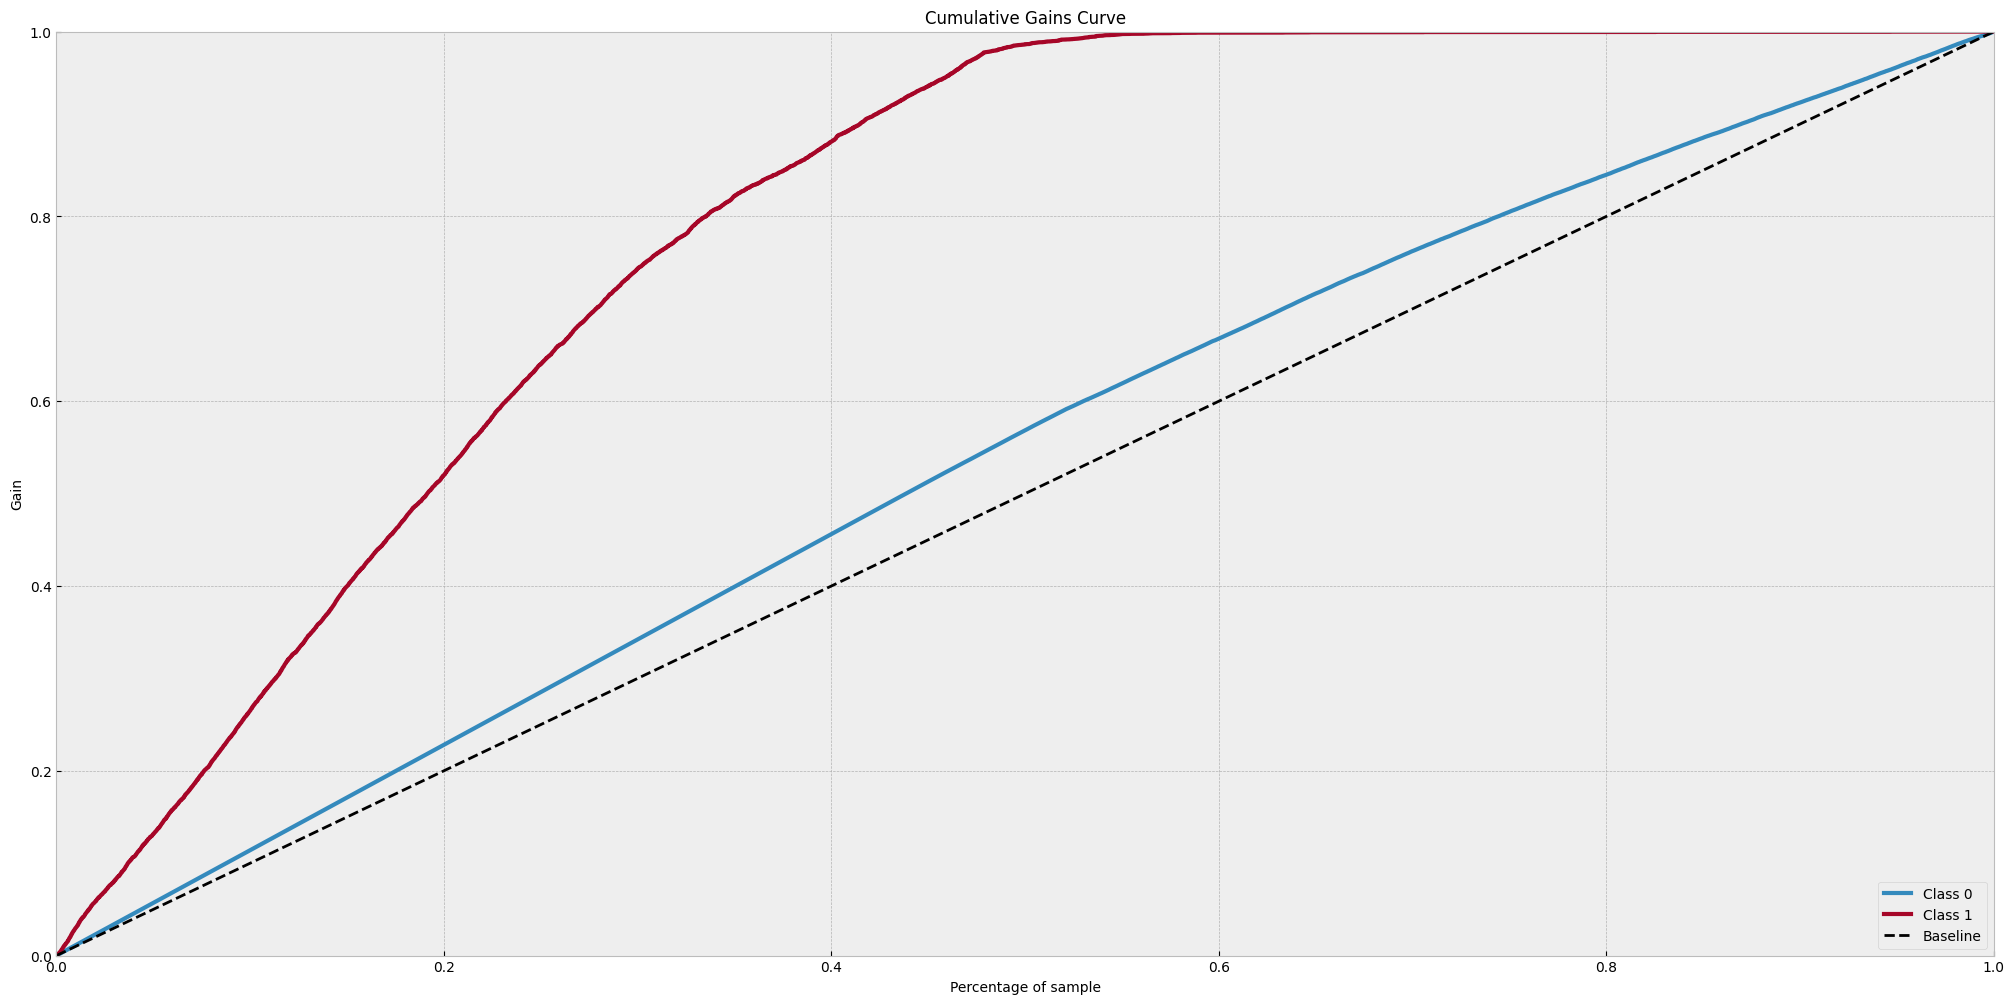

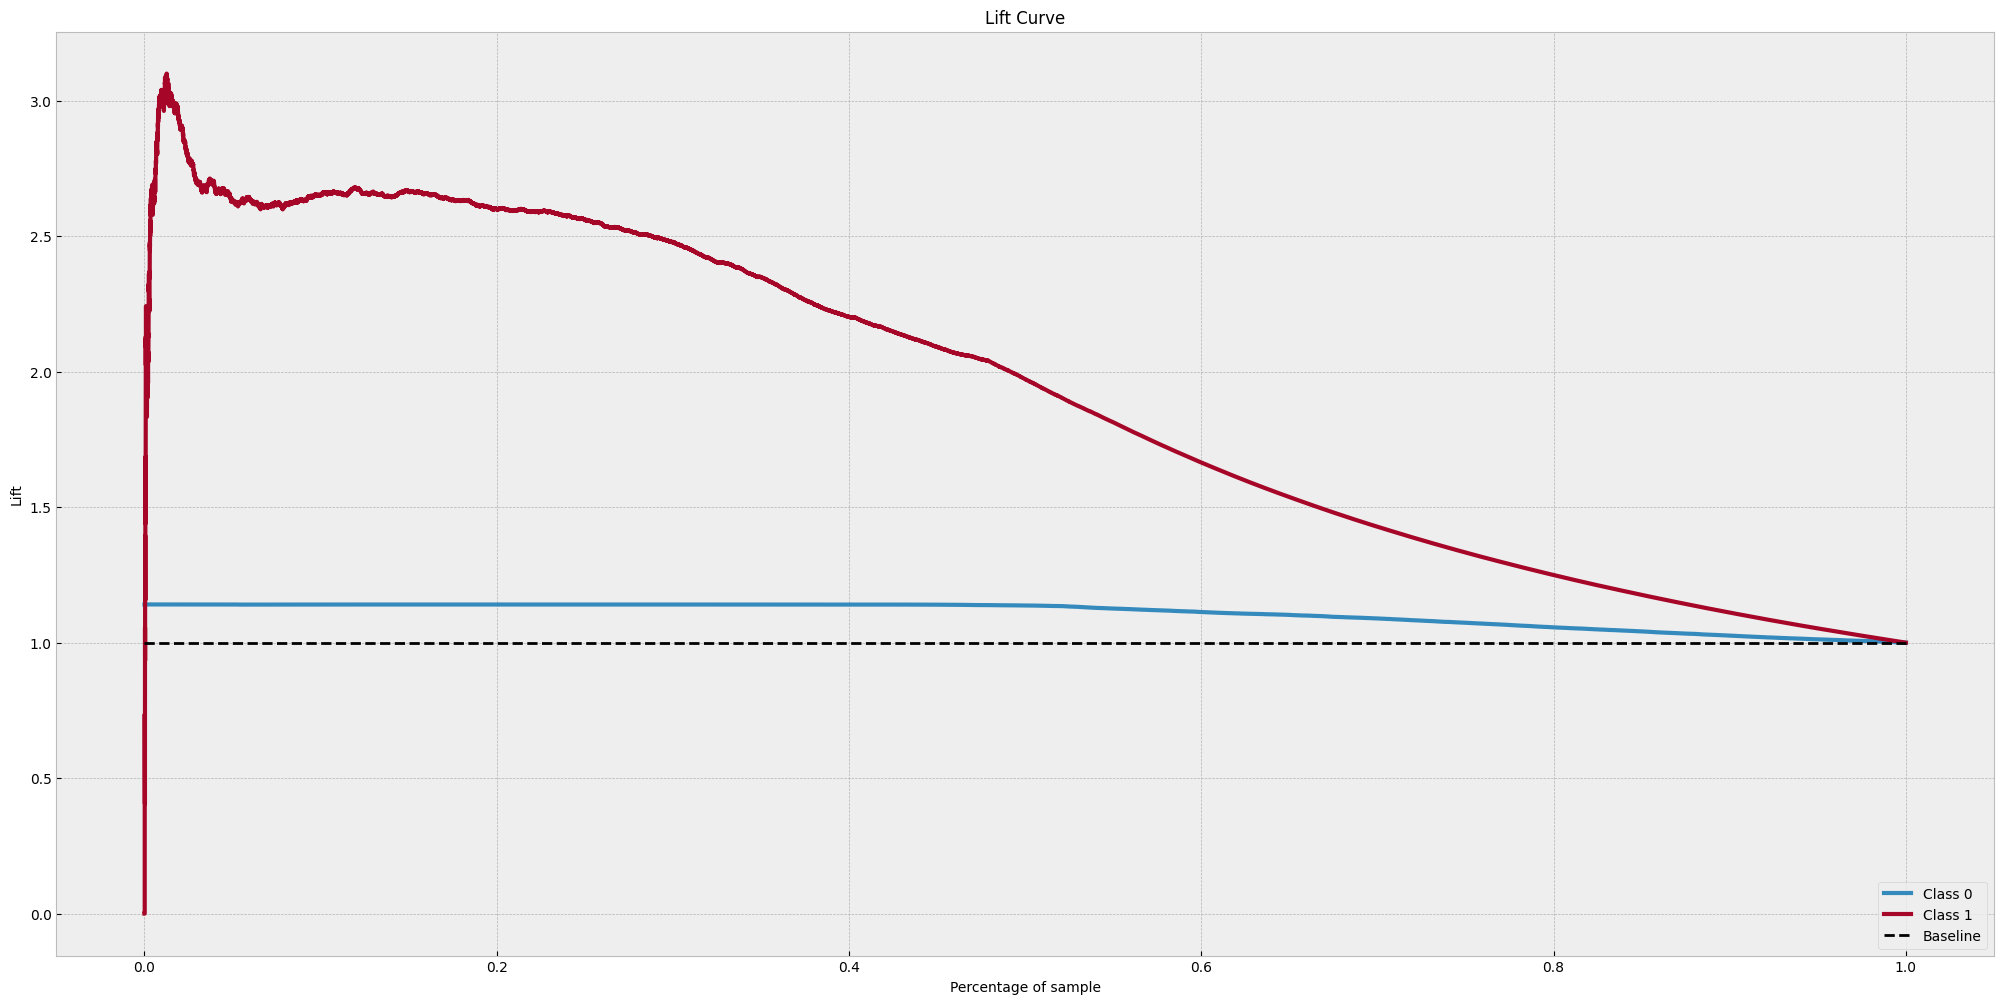

In [47]:
#Plot Performance Curves

#Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr_)

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_lr_);

In [48]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_lr)
avg_precision = mt.average_precision_score(y_val, yhat_lr, average='micro')
recall = mt.recall_score(y_val, yhat_lr)
f1_score = mt.f1_score(y_val, yhat_lr, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.16129
AVG_Precision: 0.12354
Recall: 0.00053
F1 Score: 0.46754


In [49]:
##Export the model pkl
#pickle.dump(lr, open('lr_model.pkl', 'wb' ))

### 6.2. XGBoost Classifier

In [50]:
##Grid Search
##Model Definition
#xgb_model = XGBClassifier(min_child_weight=1)
#
##Parameters Definition
#parameters = {'n_estimators': [100, 500],
#              'max_depth': [10, 20]}
#
#xgb_grd_src = GridSearchCV(estimator=xgb_model,
#                           param_grid=parameters,
#                           cv=3,
#                           scoring='precision')
#
##Model Training
#xgb_grdsrc_result = xgb_grd_src.fit(X_train, y_train)
#
##Score
#print('Best Score: {:.5f}'.format(xgb_grdsrc_result.best_score_))
#print('Best Parameters: {}'.format(xgb_grdsrc_result.best_params_))

In [51]:
#Model Definition
xgb = XGBClassifier(random_state=42) 

#Model Training
xgb.fit(X_train, y_train)

#Model Prediction
yhat_xgb = xgb.predict(X_val)
yhat_xgb_ = xgb.predict_proba(X_val)

In [52]:
#Cross Validation XGB
xgb_cv = cross_val_score(xgb, X, y, scoring='precision', cv=5)
print(xgb_cv)
print('AVG CV: {:.5f}'.format(xgb_cv.mean()))
print('STD CV: {:.5f}'.format(xgb_cv.std()))

[0.44880174 0.43775934 0.46258503 0.4765625  0.49099099]
AVG CV: 0.46334
STD CV: 0.01900


#### 6.2.1. Performance XGBoost

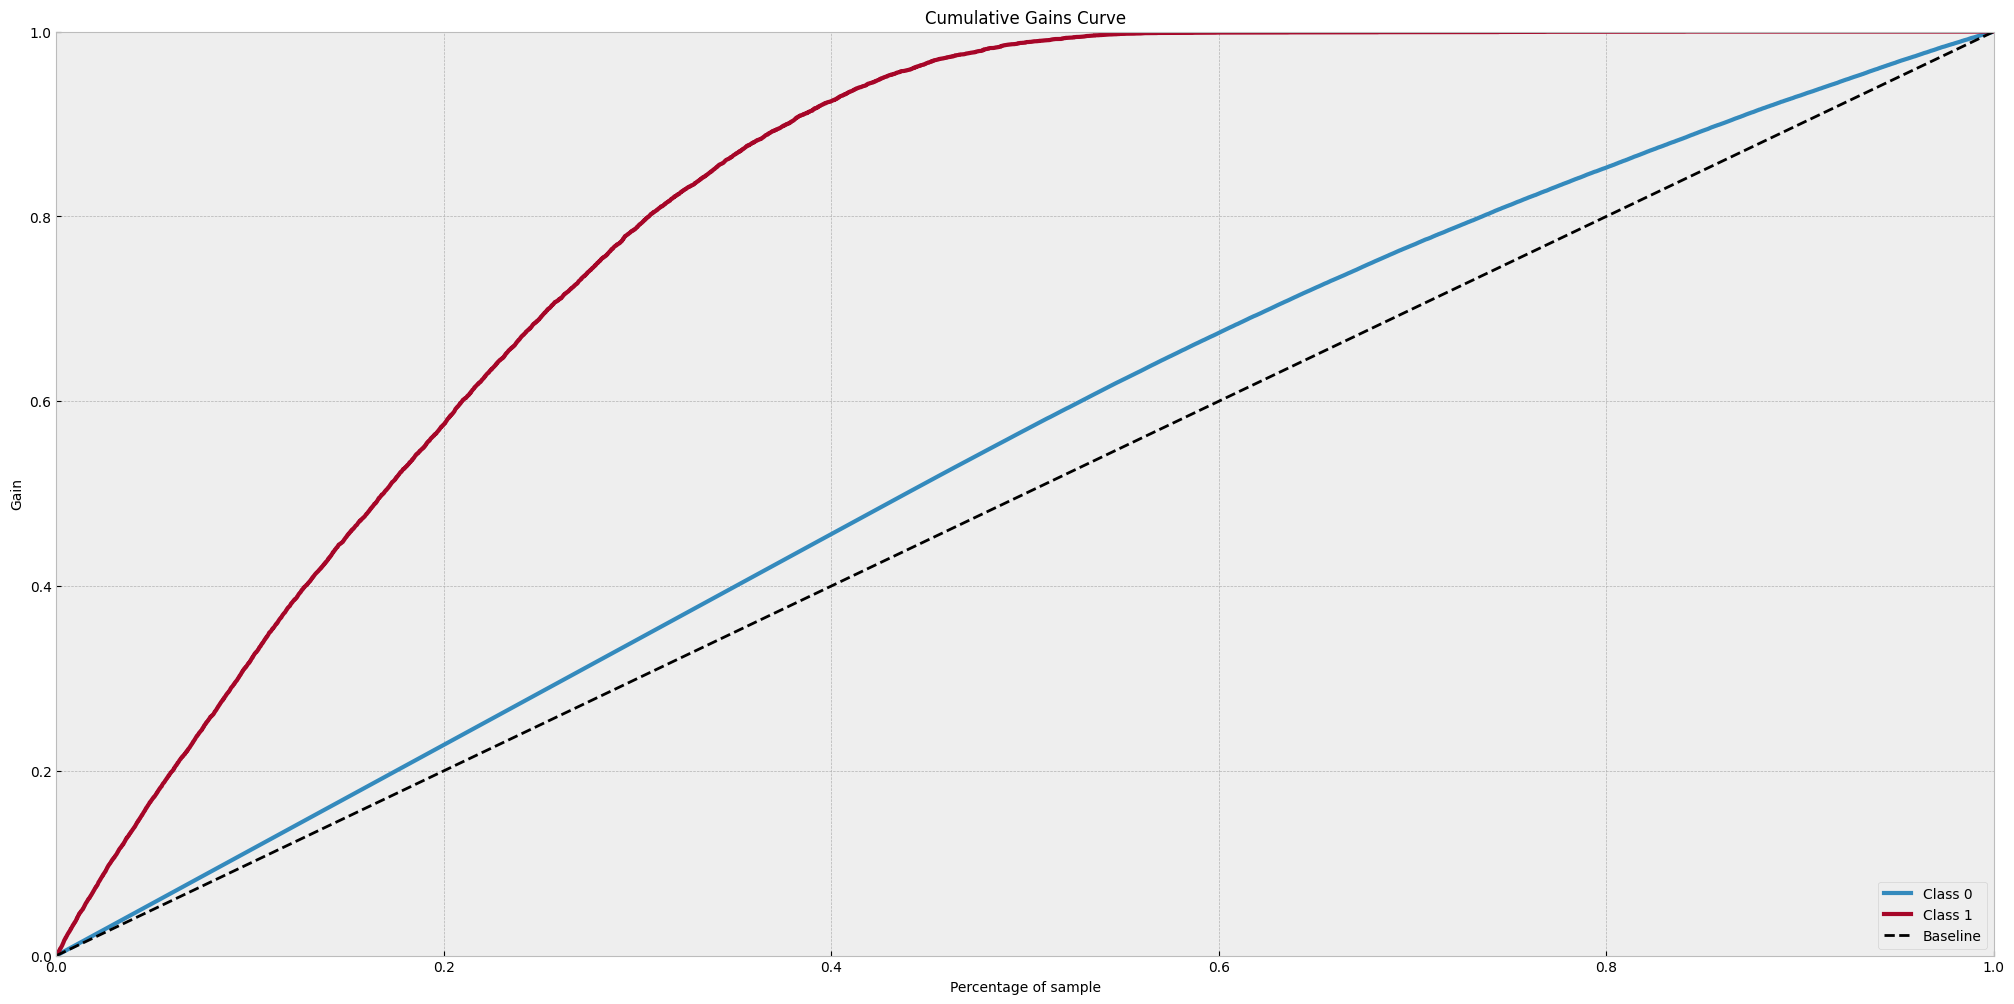

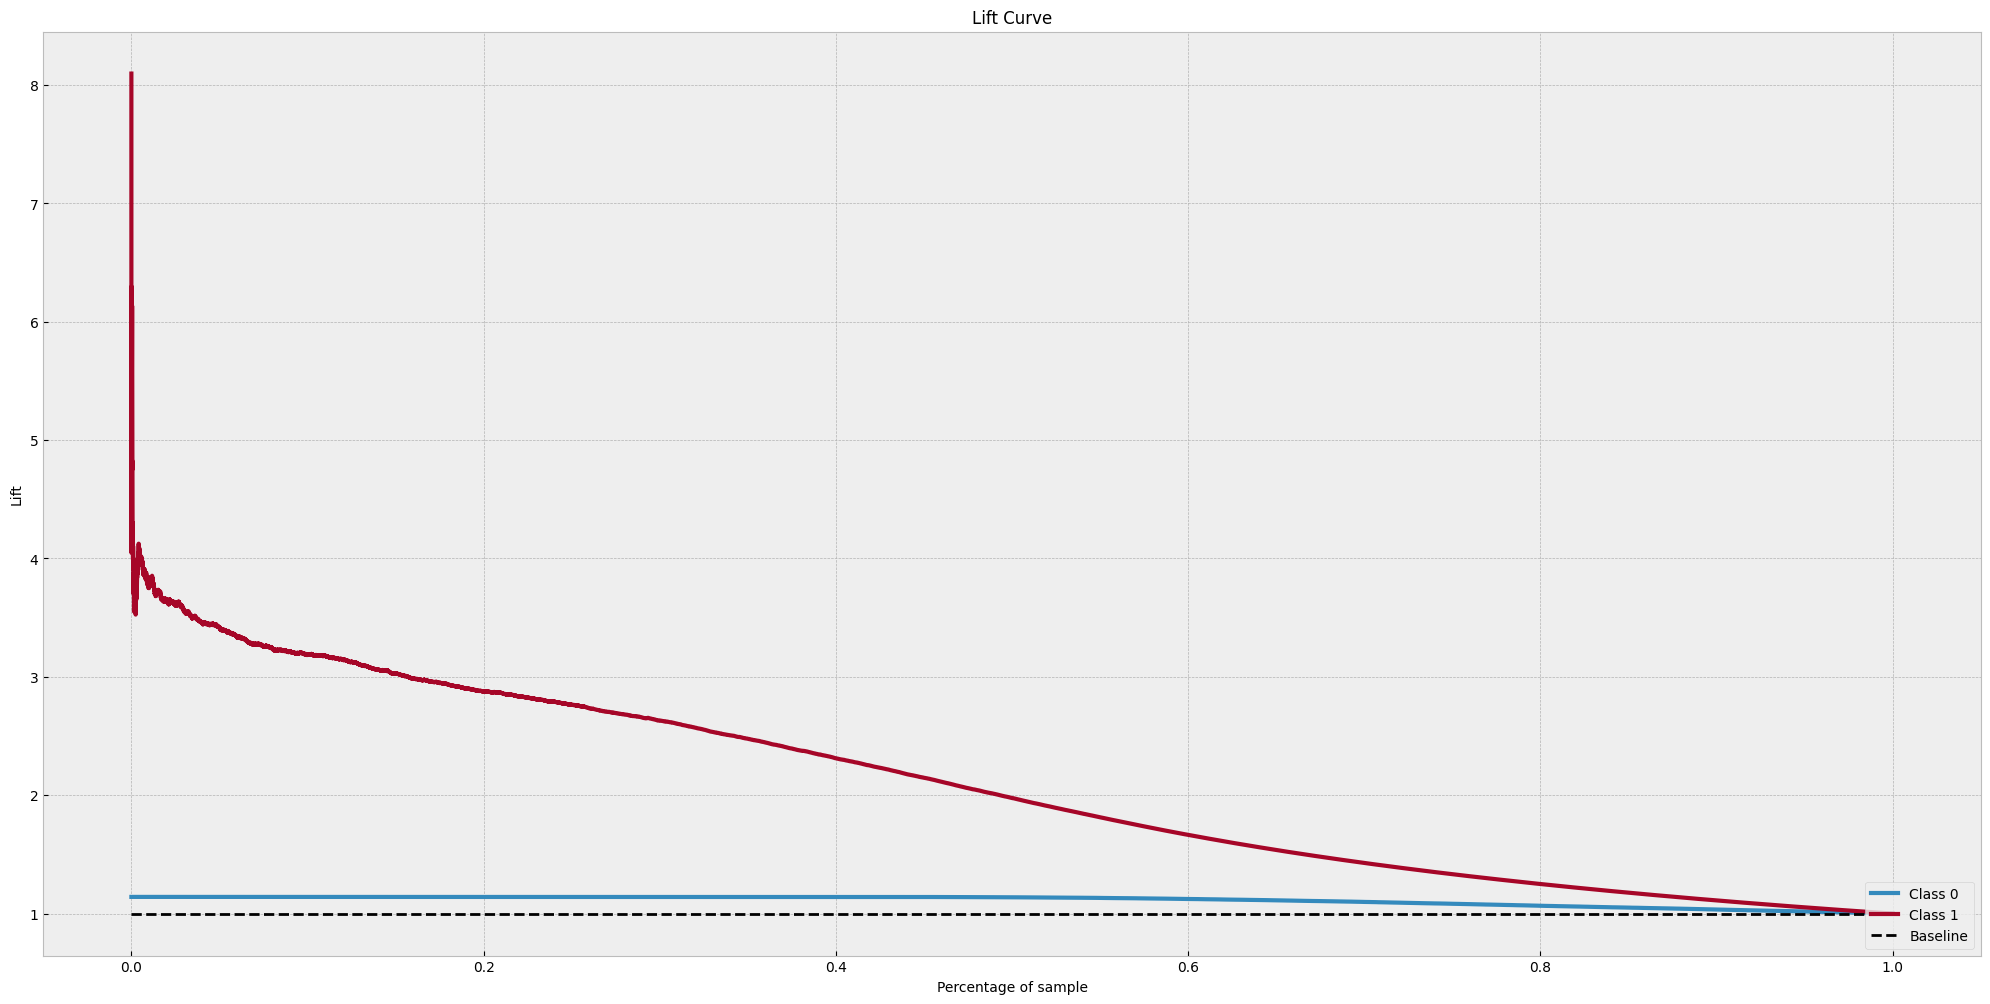

In [53]:
#Plot Performance Curves

#Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb_)

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_xgb_);

In [54]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_xgb)
avg_precision = mt.average_precision_score(y_val, yhat_xgb, average='micro')
recall = mt.recall_score(y_val, yhat_xgb)
f1_score = mt.f1_score(y_val, yhat_xgb, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.48847
AVG_Precision: 0.13255
Recall: 0.02475
F1 Score: 0.49049


In [55]:
#Export the model pkl
pickle.dump(xgb, open('src/models/xgb_model.pkl', 'wb' ))

### 6.3. K-Nearest Neighbors Classifier

In [56]:
#Model Definition
knn = nh.KNeighborsClassifier(n_neighbors=9) 

#Model Training
knn.fit(X_train, y_train)

#Model Prediction
yhat_knn = knn.predict(X_val)
yhat_knn_ = knn.predict_proba(X_val)

In [57]:
#Cross Validation KNN
knn_cv = cross_val_score(knn, X, y, scoring='precision', cv=5)
print(knn_cv)
print('AVG CV: {:.5f}'.format(knn_cv.mean()))
print('STD CV: {:.5f}'.format(knn_cv.std()))

[0.34893883 0.35165503 0.34602989 0.34378882 0.35688296]
AVG CV: 0.34946
STD CV: 0.00456


#### 6.3.1. Performance KNN

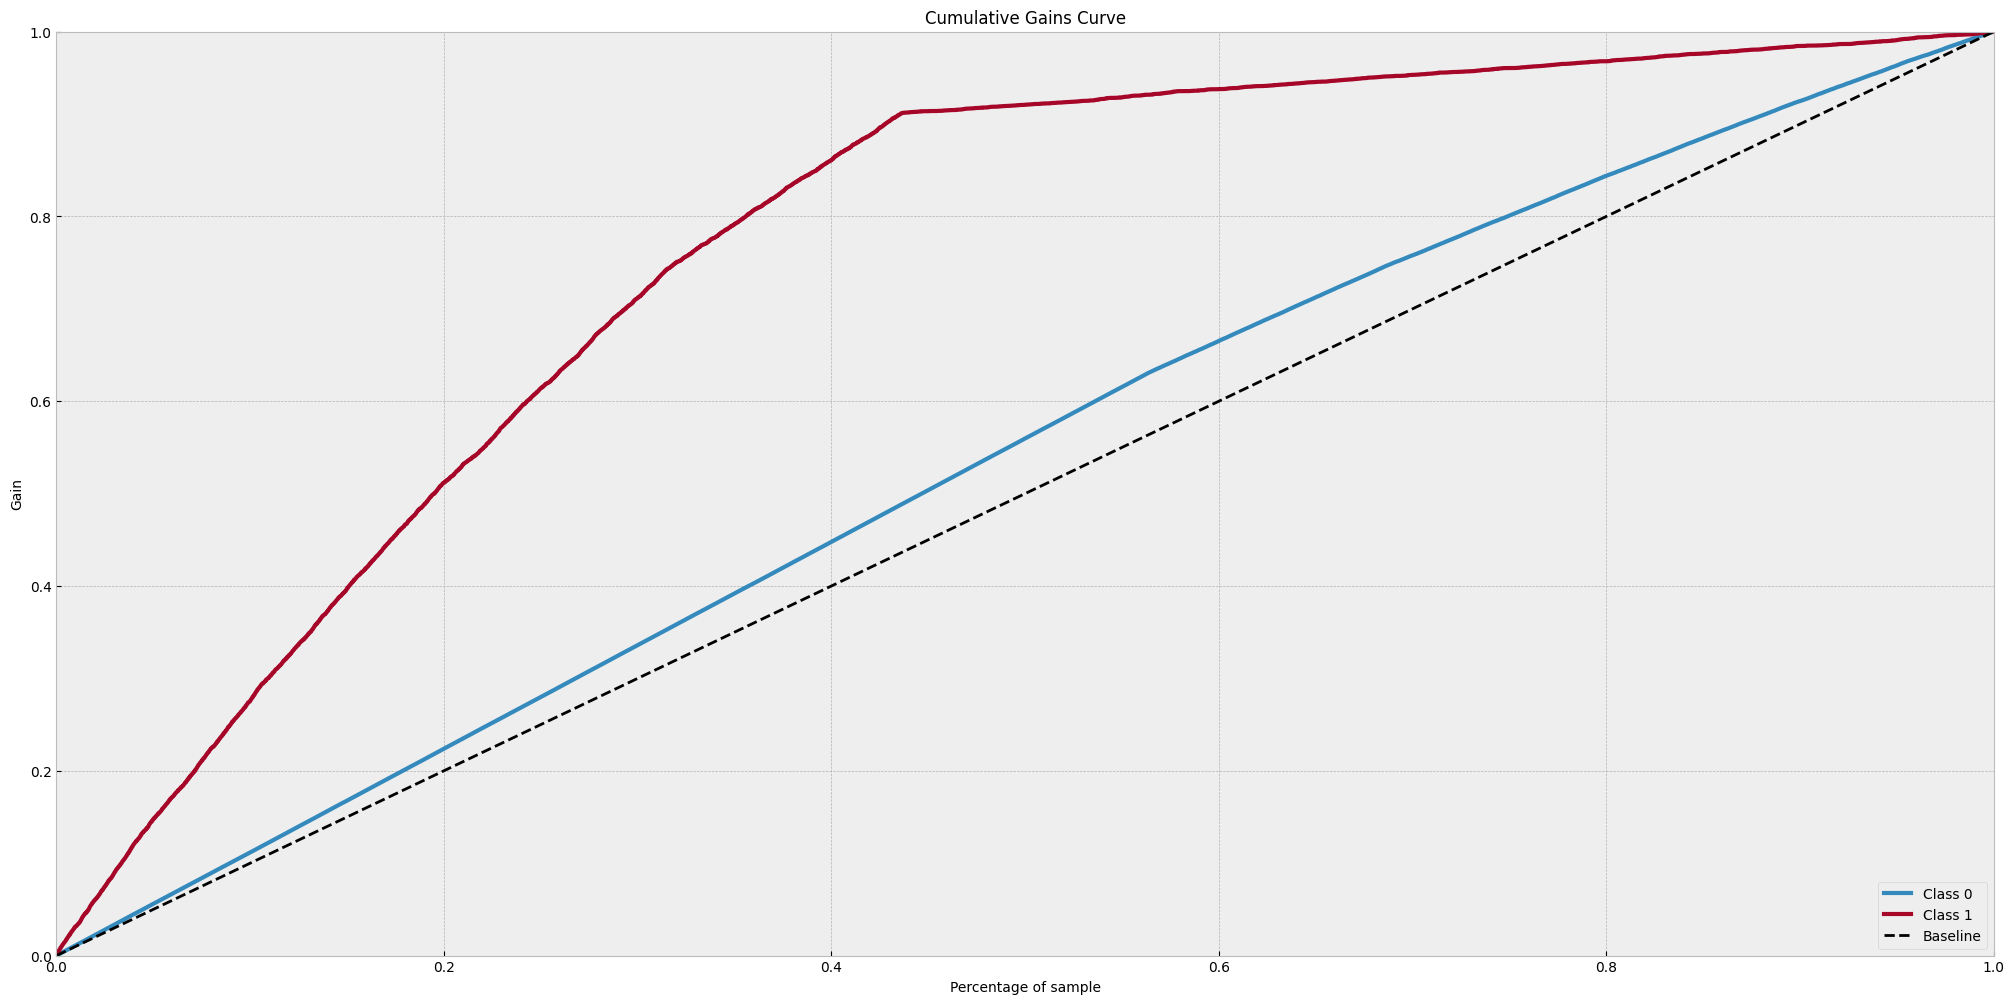

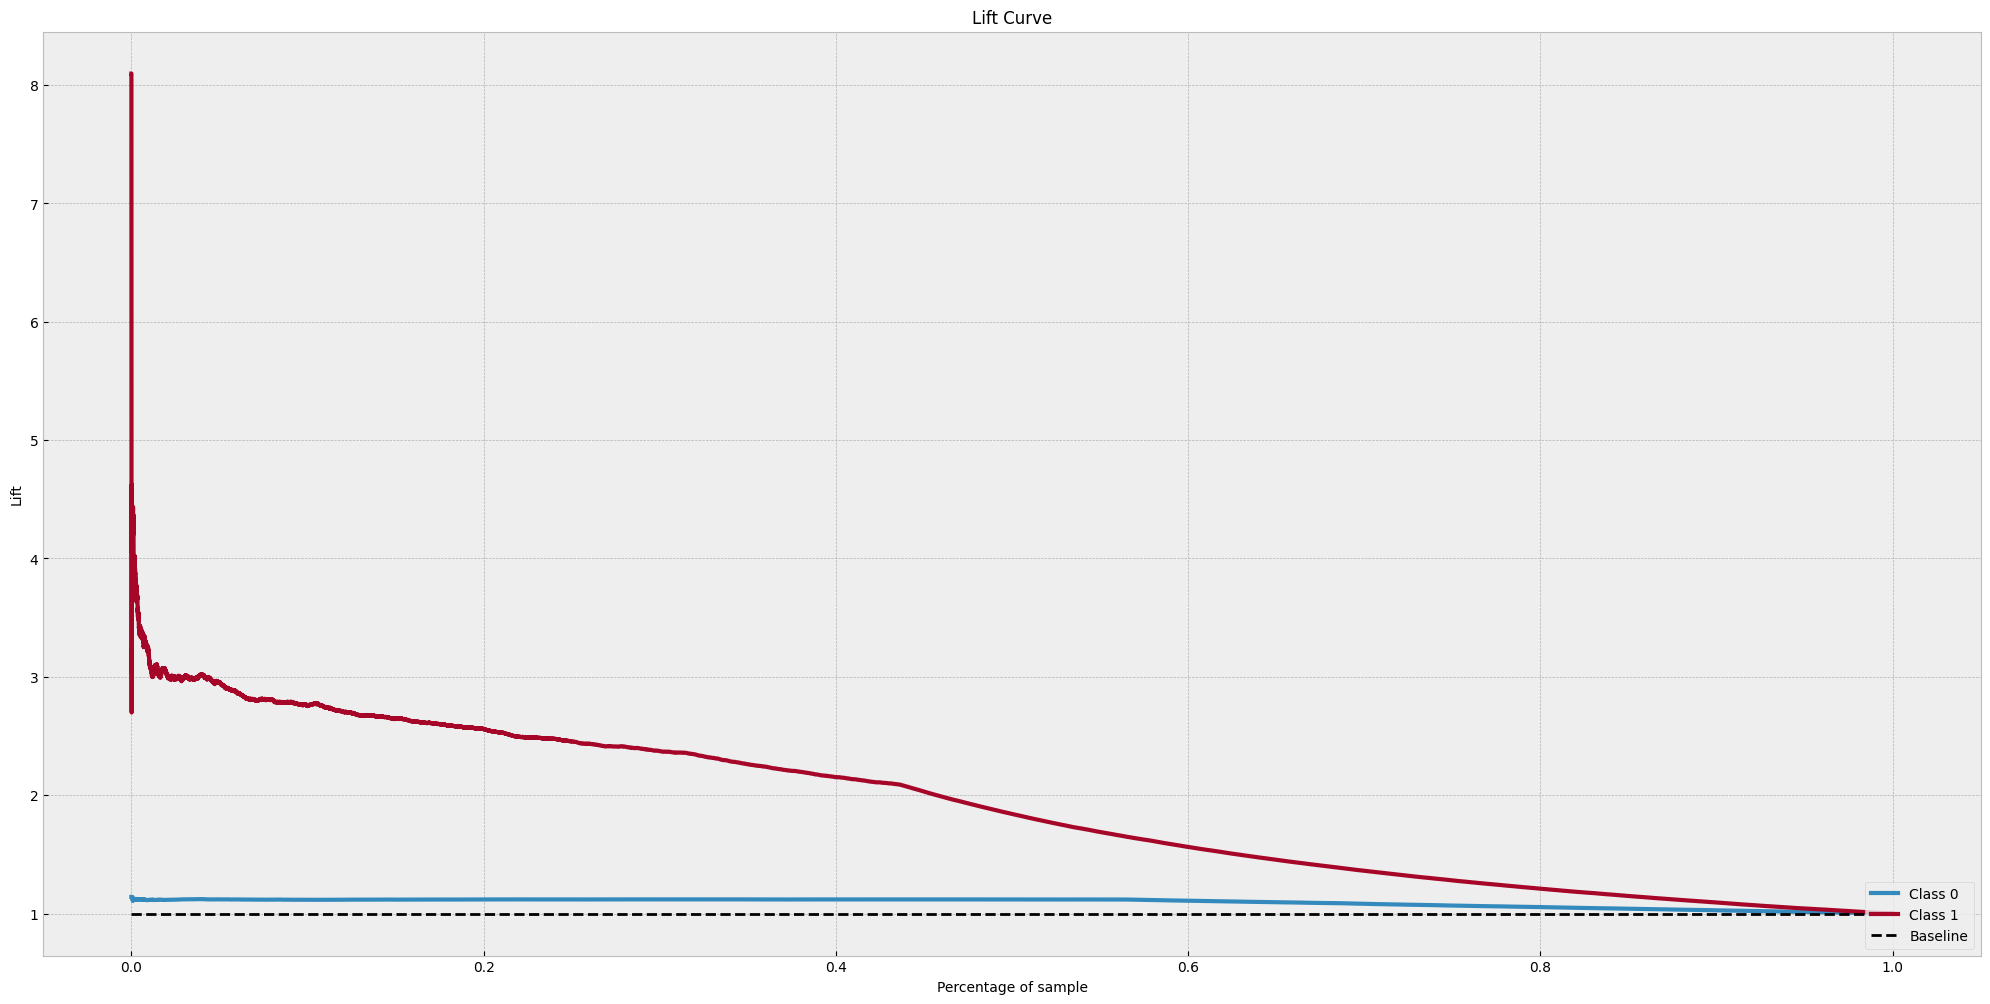

In [58]:
#Plot Performance Curves

#Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn_)

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_knn_);

In [59]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_knn)
avg_precision = mt.average_precision_score(y_val, yhat_knn, average='micro')
recall = mt.recall_score(y_val, yhat_knn)
f1_score = mt.f1_score(y_val, yhat_knn, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.36964
AVG_Precision: 0.15554
Recall: 0.13011
F1 Score: 0.55945


In [60]:
##Export the model pkl
#pickle.dump(knn, open('knn_model.pkl', 'wb' ))

### 6.4. Extra Trees Classifier

In [61]:
#Model Definition
et = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42) 

#Model Training
et.fit(X_train, y_train)

#Model Prediction
yhat_et = et.predict(X_val)
yhat_et_ = et.predict_proba(X_val)

In [62]:
#Cross Validation ET
et_cv = cross_val_score(et, X, y, scoring='precision', cv=5)
print(et_cv)
print('AVG CV: {:.5f}'.format(et_cv.mean()))
print('STD CV: {:.5f}'.format(et_cv.std()))

[0.34511861 0.34266517 0.33512424 0.33922755 0.34258198]
AVG CV: 0.34094
STD CV: 0.00346


#### 6.4.1. Performance Extra Trees

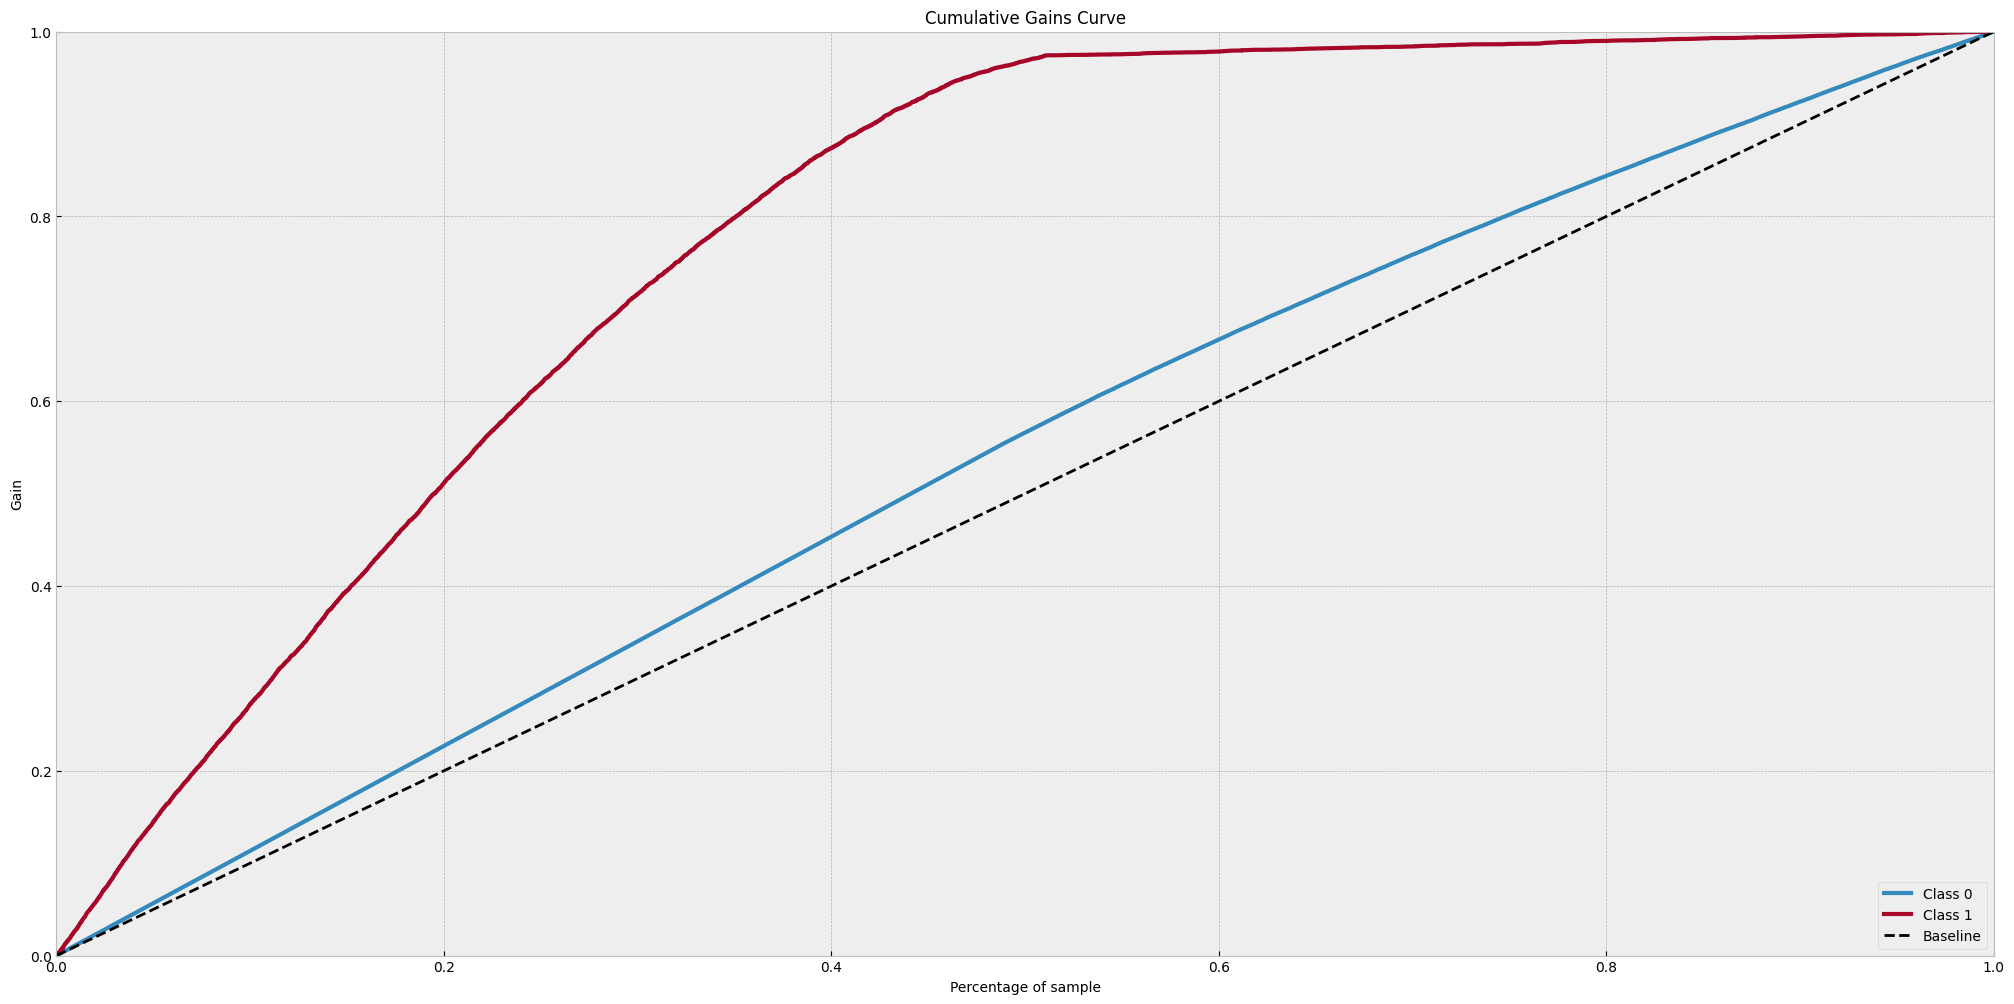

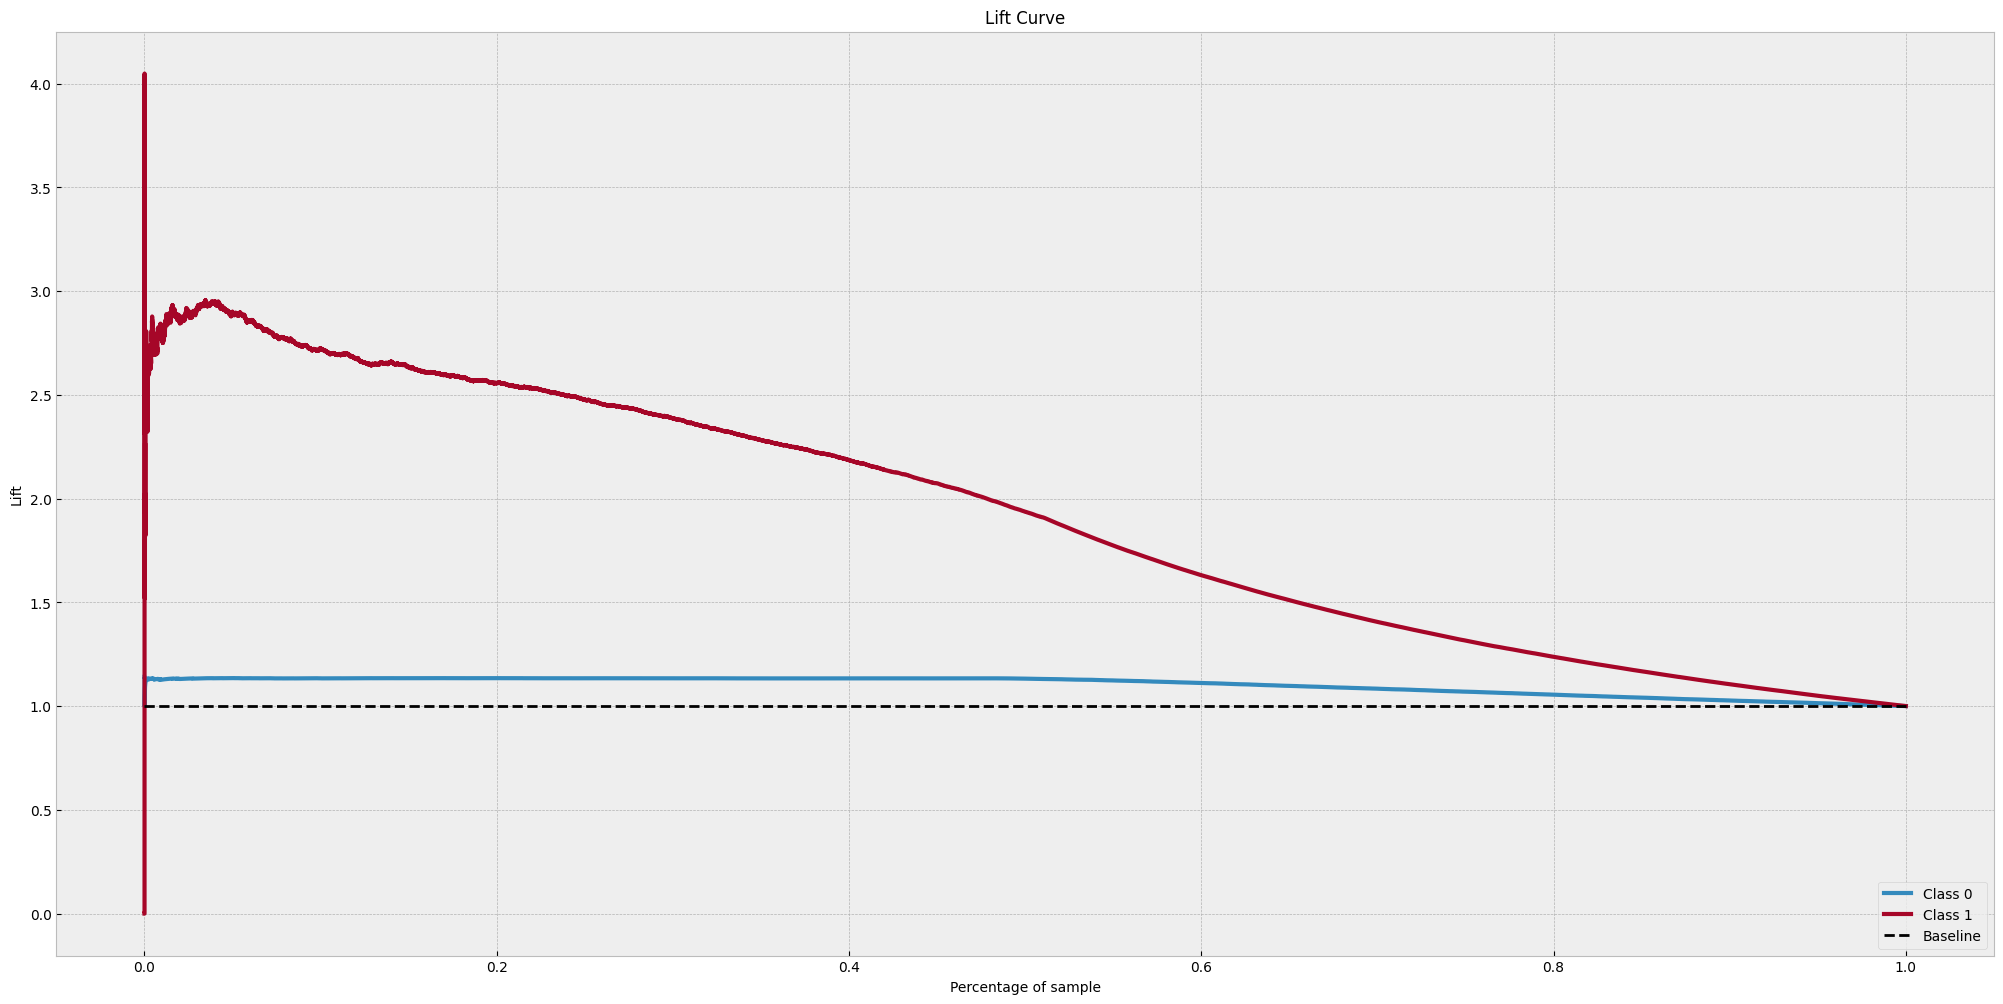

In [63]:
#Plot Performance Curves

#Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_et_)

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_et_);

In [64]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_et)
avg_precision = mt.average_precision_score(y_val, yhat_et, average='micro')
recall = mt.recall_score(y_val, yhat_et)
f1_score = mt.f1_score(y_val, yhat_et, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.35615
AVG_Precision: 0.16157
Recall: 0.16357
F1 Score: 0.57367


In [65]:
##Export the model pkl
#pickle.dump(et, open('et_model.pkl', 'wb' ))

### 6.5. Random Forest Classifier

In [66]:
#Model Definition
rf = en.RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42) 

#Model Training
rf.fit(X_train, y_train)

#Model Prediction
yhat_rf = rf.predict(X_val)
yhat_rf_ = rf.predict_proba(X_val)

In [67]:
#Cross Validation RF
rf_cv = cross_val_score(rf, X, y, scoring='precision', cv=5)
print(rf_cv)
print('AVG CV: {:.5f}'.format(rf_cv.mean()))
print('STD CV: {:.5f}'.format(rf_cv.std()))

[0.36340206 0.35630204 0.35430369 0.35366552 0.36296296]
AVG CV: 0.35813
STD CV: 0.00422


#### 6.5.1. Performance Random Forest

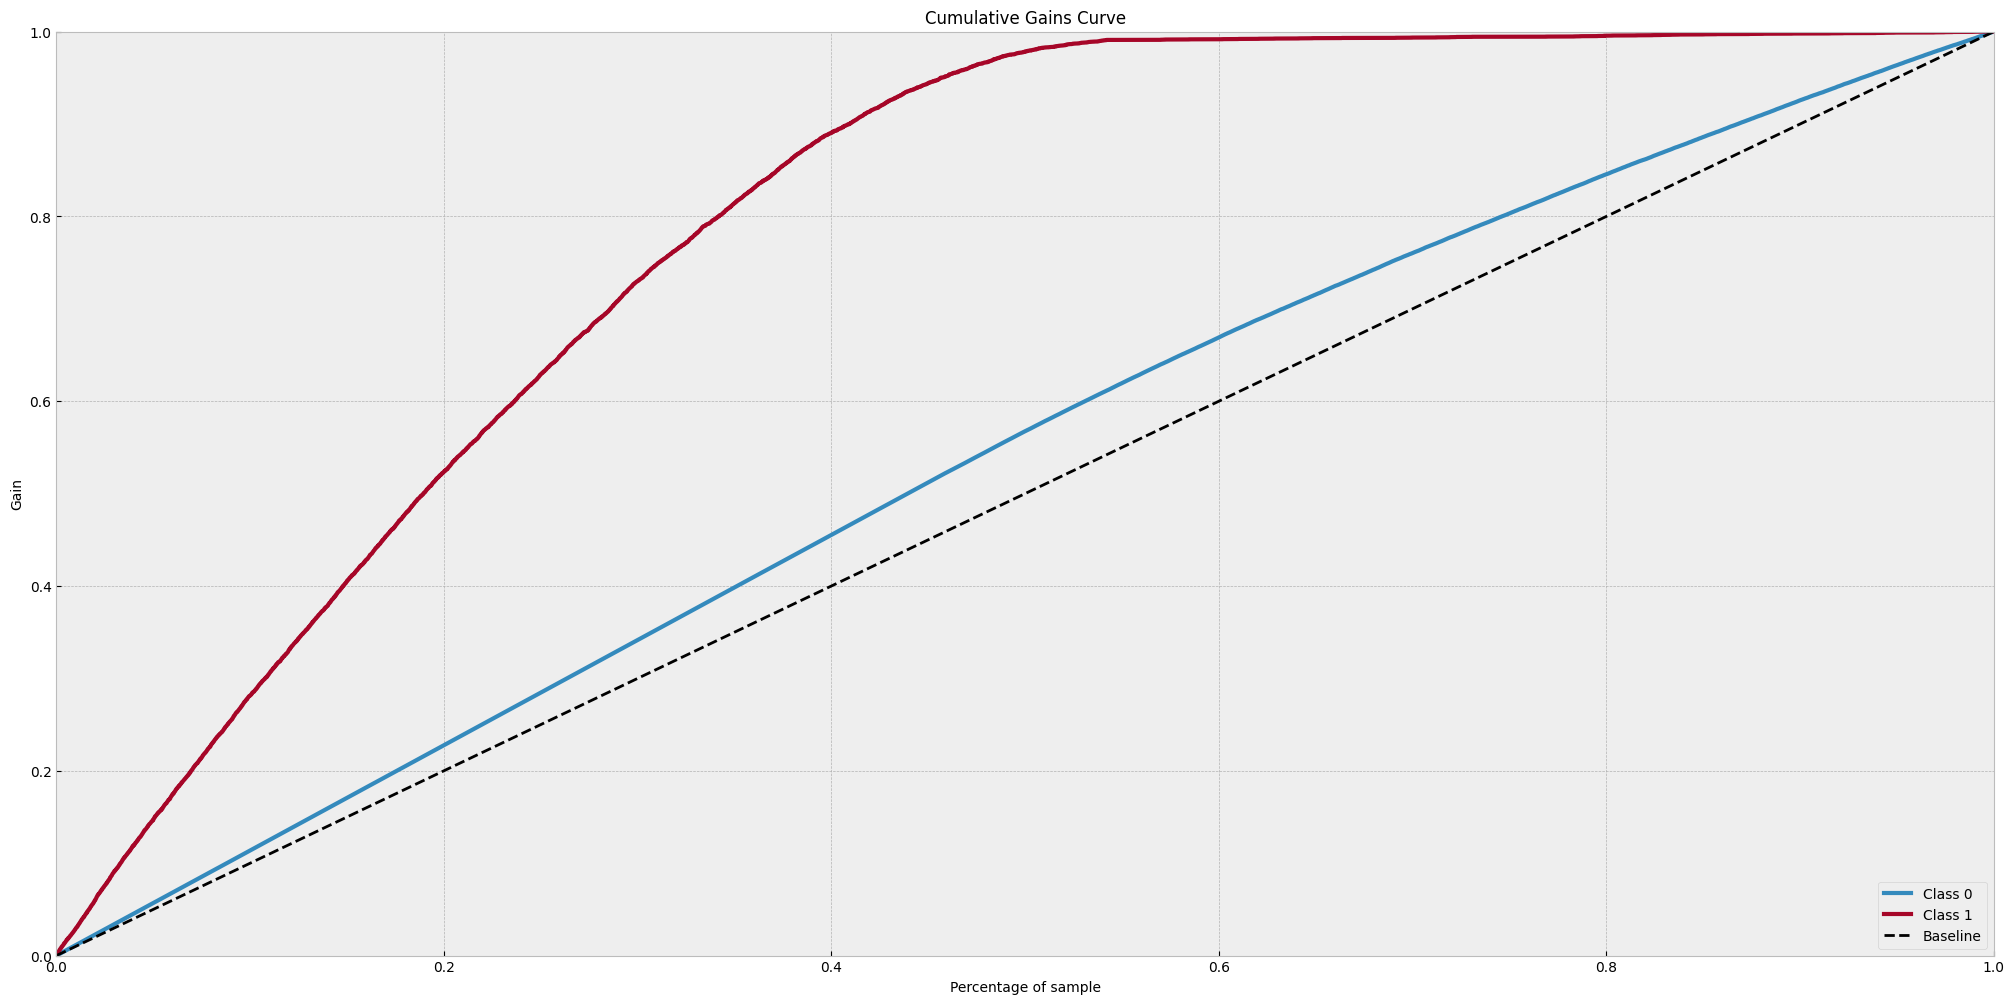

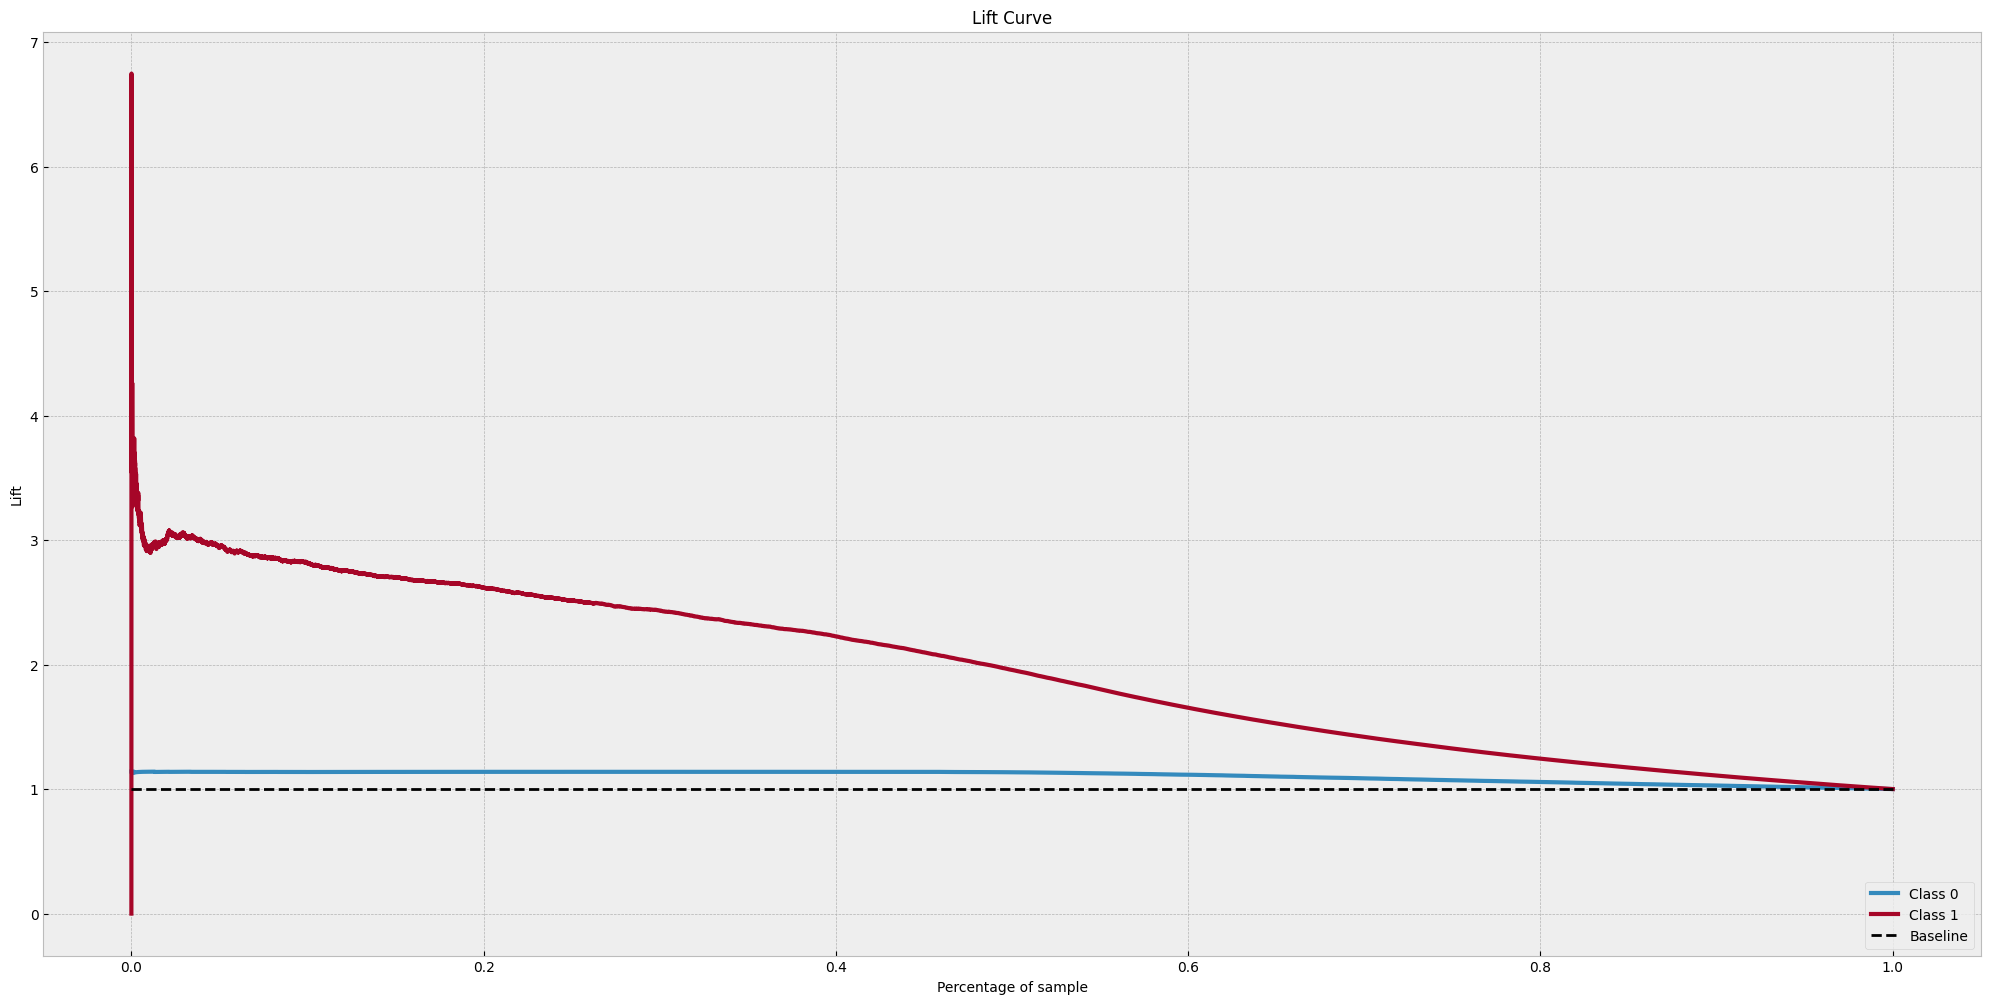

In [68]:
#Plot Performance Curves

#Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf_)

#Lift Curve
skplt.metrics.plot_lift_curve(y_val, yhat_rf_);

In [69]:
#Show metrics of performance (Only on Predict cases)
precision = mt.precision_score(y_val, yhat_rf)
avg_precision = mt.average_precision_score(y_val, yhat_rf, average='micro')
recall = mt.recall_score(y_val, yhat_rf)
f1_score = mt.f1_score(y_val, yhat_rf, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.36781
AVG_Precision: 0.15637
Recall: 0.13447
F1 Score: 0.56148


In [70]:
##Export the model pkl
#pickle.dump(rf, open('rf_model.pkl', 'wb' ))

### 6.6. Ensemble Method

In [72]:
#Merge data to compare
ensemble = pd.DataFrame([yhat_lr, yhat_xgb, yhat_knn, yhat_et, yhat_rf]).T
ensemble.columns = ['yhat_lr', 'yhat_xgb', 'yhat_knn', 'yhat_et', 'yhat_rf']
moda = ensemble.mode(axis=1)[0]
ensemble['pred'] = moda

#Collect values for test performance
yhat_en = ensemble['pred']

#### 6.6.1. Performance Ensemble Method

In [73]:
#Show metrics of performance
precision = mt.precision_score(y_val, yhat_en)
avg_precision = mt.average_precision_score(y_val, yhat_en, average='micro')
recall = mt.recall_score(y_val, yhat_en)
f1_score = mt.f1_score(y_val, yhat_en, average='macro')

print('Precision: {:.5f}'.format(precision))
print('AVG_Precision: {:.5f}'.format(avg_precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.42038
AVG_Precision: 0.13601
Recall: 0.04206
F1 Score: 0.50458


## 7.0. General Performance

In [74]:
#Total metrics of performance

#Linear Regression
precision_lr = mt.precision_score(y_val, yhat_lr)
recall_lr = mt.recall_score(y_val, yhat_lr)

#XGBoost
precision_xgb = mt.precision_score(y_val, yhat_xgb)
recall_xgb = mt.recall_score(y_val, yhat_xgb)

#K-Nearest Neighbors
precision_knn = mt.precision_score(y_val, yhat_knn)
recall_knn = mt.recall_score(y_val, yhat_knn)

#Extra Trees
precision_et = mt.precision_score(y_val, yhat_et)
recall_et = mt.recall_score(y_val, yhat_et)

#Ranbom Forest
precision_rf = mt.precision_score(y_val, yhat_rf)
recall_rf = mt.recall_score(y_val, yhat_rf)

#Ensemble
precision_en = mt.precision_score(y_val, yhat_en)
recall_en = mt.recall_score(y_val, yhat_en)

In [75]:
#Show performance on table
tab_reg_test = [['Logistic Regression', precision_lr, recall_lr],
         ['XGBoost', precision_xgb, recall_xgb],
         ['K-Nearest Neighbors', precision_knn, recall_knn],
         ['Extra Trees', precision_et, recall_et],
         ['Random Forest', precision_rf, recall_rf],
         ['Ensemble', precision_en, recall_en]]

head_reg = ['MODEL', 'Precision', 'Recall']

print('> General Performance:')
print(tabulate(tab_reg_test, head_reg, tablefmt='fancy_grid'))

> General Performance:
╒═════════════════════╤═════════════╤═════════════╕
│ MODEL               │   Precision │      Recall │
╞═════════════════════╪═════════════╪═════════════╡
│ Logistic Regression │    0.16129  │ 0.000531067 │
├─────────────────────┼─────────────┼─────────────┤
│ XGBoost             │    0.48847  │ 0.0247477   │
├─────────────────────┼─────────────┼─────────────┤
│ K-Nearest Neighbors │    0.369644 │ 0.130112    │
├─────────────────────┼─────────────┼─────────────┤
│ Extra Trees         │    0.356152 │ 0.163569    │
├─────────────────────┼─────────────┼─────────────┤
│ Random Forest       │    0.367809 │ 0.134466    │
├─────────────────────┼─────────────┼─────────────┤
│ Ensemble            │    0.420382 │ 0.0420605   │
╘═════════════════════╧═════════════╧═════════════╛


### 7.1. Performance at K

In [76]:
#Prepare Dataset
df5 = X_val.copy()
df5['response'] = y_val.copy()

#Propensity Score
yhat = yhat_xgb_
df5['score'] = yhat[:, 1].tolist()

#Sort clients by Propensity Score
df5 = df5.sort_values('score', ascending=False)

In [77]:
#Compute Precision at K
k_prec = 20
prec_at_k, data = precision_at_k(df5, k=k_prec)

#Compute Recall at K
k_rec = 10
rec_at_k, data = recall_at_k(df5, k=k_rec)

print('Precision at {}: {:.2f}%'.format(k_prec, prec_at_k*100))
print('Recall at {}: {:.2f}%'.format(k_rec, rec_at_k*100))

Precision at 20: 66.67%
Recall at 10: 0.08%


## 8.0. Model Application to Test Data

### 8.1. Load Test Data

In [78]:
#Load test data
df_x = pd.read_csv('data/test.csv')

In [79]:
#Counting number of rows and columns of the dataset
print('Test Rows: {}'.format(df_x.shape[0]))
print('Test Cols: {}'.format(df_x.shape[1]))

Test Rows: 127037
Test Cols: 11


### 8.2. Processing Test Data

In [80]:
#Rename columns
df_x = rename_cols(df_x, train=False)

#Feature Engineering
df_x = feature_eng(df_x)

#Data Preparation
df_x = feature_opt(df_x)

In [81]:
#Checking number of rows and columns of the dataset after Data Processing
print('Test Rows: {}'.format(df_x.shape[0]))
print('Test Cols: {}'.format(df_x.shape[1]))

Test Rows: 127037
Test Cols: 11


### 8.2. Import Model

In [82]:
#Import the model pkl
with open('src/models/xgb_model.pkl', 'rb') as model:
    xgb = pickle.load(model)

### 8.3. Application to Test Data

In [83]:
#Logistic Regression application to test data
yhat_lr_x = lr.predict(df_x[cols_sel])

#KNN application to test data
yhat_knn_x = knn.predict(df_x[cols_sel])

#Extra Trees application to test data
yhat_et_x = et.predict(df_x[cols_sel])

#Random Forest application to test data
yhat_rf_x = rf.predict(df_x[cols_sel])

#XGBoost application to test data - Model Selected by Performance
yhat_xgb_x = xgb.predict(df_x[cols_sel])
yhat_xgb_x_ = xgb.predict_proba(df_x[cols_sel])

## 9.0. Export Results

In [86]:
#Prepare data to export XGBoost
df_x['response'] = yhat_xgb_x
df_x['response_prob_0'] = yhat_xgb_x_[:,0]
df_x['response_prob_1'] = yhat_xgb_x_[:,1]

#Dataframe for export
df_results_xgb = df_x

#Dataframe short - ID, Response
results_xgb = pd.concat([df_x['id'], pd.Series(yhat_xgb_x)], axis = 1).rename(columns = {0: 'response'})

#Export data
df_results_xgb.to_csv('data/df_results.csv', index=False)
results_xgb.to_csv('data/results.csv', index=False)

In [87]:
#Check Dataframe Results
df_results_xgb

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,response_prob_0,response_prob_1
0,381110,1,0.08,1,0.02,1,0.00,0,0.00,0.35,0.15,0,1.00,0.00
1,381111,1,0.31,1,0.28,0,0.50,1,0.00,0.00,0.35,0,0.65,0.35
2,381112,1,0.42,1,0.28,0,0.50,1,0.00,0.19,0.65,0,0.72,0.28
3,381113,1,0.06,1,0.01,1,0.00,1,0.00,0.35,0.61,0,0.99,0.01
4,381114,1,0.11,1,0.28,1,0.00,0,0.00,0.35,0.99,0,1.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127032,508142,0,0.09,1,0.01,1,0.00,0,0.00,0.35,0.16,0,1.00,0.00
127033,508143,0,0.28,1,0.28,0,0.50,1,0.00,0.03,0.54,0,0.55,0.45
127034,508144,1,0.02,1,0.05,1,0.00,0,0.00,0.35,0.22,0,1.00,0.00
127035,508145,1,0.78,1,0.28,1,0.50,0,0.00,0.21,0.88,0,1.00,0.00


In [88]:
#Check Results
df_results_xgb[['id', 'response']].groupby('response').count().reset_index()

,response,id
0,0,126444
1,1,593


In [90]:
#Ensemble Method

#Prepare data to export Ensemble
ensemble = pd.DataFrame([yhat_lr_x, yhat_xgb_x, yhat_knn_x, yhat_et_x, yhat_rf_x]).T
ensemble.columns = ['yhat_lr', 'yhat_xgb', 'yhat_knn', 'yhat_et', 'yhat_rf']
moda_x = ensemble.mode(axis=1)[0]
ensemble['pred'] = moda_x

yhat_final = ensemble['pred']
df_x_en = df_x.copy()
df_x_en['response'] = yhat_final
results_en = df_x_en[['id', 'response']].copy()

#Dataframe for export
df_results_en = df_x_en

#Export data
df_results_en.to_csv('data/df_ensemble_results.csv', index=False)
results_en.to_csv('data/ensemble_results.csv', index=False)

#Check Results
results_en[['id', 'response']].groupby('response').count().reset_index()

,response,id
0,0,125615
1,1,1422
